---

# Ethical Data Science 2022/2023

# Course Assignment

## Flàvia Ferrús Marimón

---

# Assignment: Risk predicition of criminal re-offense



**This notebook** presents an exploration of a sub-set of data from **[SAVRY](https://www.parinc.com/Products/Pkey/390)** (Structured Assessment of Violence Risk in Youth) applied to young offenders in Catalonia. 

SAVRY is a risk assessment tool, that supports structured professional judgement. SAVRY contains 24 risk factors, in which each item (variables `V65*` to `V88*`) can have one of three values (low=0, moderate=1, high=2), for a total score between 0 and 48 points. 

+ Human score: There is also a score by a professional (variable `V56_@R1_resum_risc_global_reverse`) that can be low, moderate, or high. 
+ Recividism: In this dataset, there is information about whether people committed a new crime after the evaluation.  The variable `V115_reincidencia_2015` represents Recidivism (year 2015).
+ The variable `V60_SAVRY_total_score` contains a sum of scores in the risk items of SAVRY. This score can be seen as a baseline automatic method.

Features values can be found in ``reincidenciaJusticiaMenors.xlsx``. The description of features can be found in ``recidivismJuvenileJustice_variables_EN.pdf``. The data file we use is a subset of data obtained by the Centre d'Estudis Jurídics i Formació Especialitzada of the Catalan government and released in 2017.

The objectives of this assignment are: 
+ To compare the performance of SAVRY and ML-based methods, in terms of both performace and fairness metrics. 
+ To analyze the causes of unfairness.
+ To explore a mitigation strategy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

### Data Exploration

In [2]:
FILENAME_DATASET = 'reincidenciaJusticiaMenors.xlsx'

df = pd.read_excel(FILENAME_DATASET)
df.head()

id V1_sexe V2_estranger V3_nacionalitat V4_nacionalitat_agrupat  \
0   691    Home     Espanyol         Espanya                     NaN   
1   956    Dona     Espanyol         Espanya                     NaN   
2  2560    Home    Estranger          Marroc                  Magrib   
3  2018    Home    Estranger          Marroc                  Magrib   
4  1650    Home     Espanyol         Espanya                     NaN   

  V5_edat_fet_agrupat V6_provincia  V7_comarca  V8_edat_fet  \
0        14 i 15 anys       Lleida      Segrià         15.0   
1        14 i 15 anys    Barcelona  Barcelonès         14.0   
2        14 i 15 anys    Barcelona       Anoia         15.0   
3        14 i 15 anys       Girona     Gironès         14.0   
4        16 i 17 anys    Tarragona  Tarragonès         17.0   

   V9_edat_final_programa  ...      V123_rein_fet_agrupat_2013  \
0                      17  ...  Contra la propietat no violent   
1                      15  ...  Contra la propietat no violent   
2                      16  ...                          Altres   
3                      15  ...                          Altres   
4                      20  ...                          Altres   

   V124_rein_fet_violencia_2013 V125_rein_fet_tipus_2013  \
0                    No violent                  Delicte   
1                    No violent                  Delicte   
2                    No violent                  Delicte   
3                    No violent                  Delicte   
4                    No violent                  Delicte   

  V126_primera_reincidencia_2013                     V127_rein_programa_2013  \
0                          Presó                           SIPC - Preventiva   
1               Justícia juvenil                 Assessorament tècnic menors   
2               Justícia juvenil      Realització de tasques socioeducatives   
3               Justícia juvenil     Permanència de cap de setmana en centre   
4                            MPA  MPA - Treballs en benefici de la comunitat   

  V128_rein_programa_agrupat_2013 V129_on_reincidencia_2013  \
0                           Presó               Només Presó   
1                             ATM                  Només JJ   
2                       Altres MO  Justícia juvenil i presó   
3                     Internament                  Només JJ   
4                             TBC                 Només MPA   

  V130_nombre_rein_agrupat_2013 V131_severitat_puntuacio_2013  \
0           2 o 3 reincidències                           2.0   
1           2 o 3 reincidències                           1.0   
2        Més de 3 reincidències                           2.0   
3        Més de 3 reincidències                           3.0   
4                1 reincidència                           1.0   

  V132_REINCIDENCIA_2013  
0                     Sí  
1                     Sí  
2                     Sí  
3                     Sí  
4                     Sí  

[5 rows x 142 columns]

In [3]:
for k,i in enumerate(list(df.columns)):
    print(k,i)

0 id
1 V1_sexe
2 V2_estranger
3 V3_nacionalitat
4 V4_nacionalitat_agrupat
5 V5_edat_fet_agrupat
6 V6_provincia
7 V7_comarca
8 V8_edat_fet
9 V9_edat_final_programa
10 V10_data_naixement
11 xxxxxxxx_FETS
12 V11_antecedents
13 V12_nombre_ante_agrupat
14 V13_nombre_fets_agrupat
15 V14_fet
16 V15_fet_agrupat
17 V16_fet_violencia
18 V17_fet_tipus
19 V19_fets_desagrupats
20 V20_nombre_antecedents
21 V21_fet_nombre
22 V22_data_fet
23 xxxxxxxx_PROGRAMA
24 V23_territori
25 V24_programa
26 V25_programa_mesura
27 V26_mesures
28 V27_durada_programa_agrupat
29 V28_temps_inici
30 V29_durada_programa
31 V30_data_inici_programa
32 V31_data_fi_programa
33 xxxxxxxxxxxxxx_MRM
34 V32_MRM_resultat
35 V33_MRM_participacio_victima
36 V34_MRM_tipus
37 V35_MRM_forma
38 V36_MRM_negatiu
39 V37_MRM_conciliacio_victimaexlus
40 V38_MRM_reparacio_economica
41 V39_MRM_reparacio_noeconomica
42 V40_MRM_reparacio_comunitaria
43 V41_MRM_participacio_trobada
44 V42_MRM_participacio_notrobada
45 V43_MRM_iniciativa_parts
46 

In [4]:
# data cleaning

df = df.dropna(subset=["V60_SAVRY_total_score", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents", 
                       "V89_@P1_impicacio_prosocial", 
                       "V90_@P2_suport_social_fort",
                       "V91_@P3_forta_vinculacio_adult_prosocial", 
                       "V92_@P4_actitud_positiva_intervencions_autoritat",
                       "V93_@P5_fort_compromis_escola_treball", 
                       "V94_@P6_perseverança_tret_personalitat"])
df = df.drop(df[df["V60_SAVRY_total_score"]>48].index)

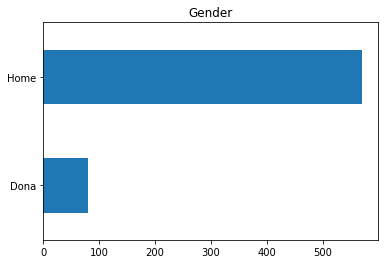

In [5]:
# data distribution by gender

_ = df['V1_sexe'].value_counts(ascending=True).plot(kind='barh', title='Gender')

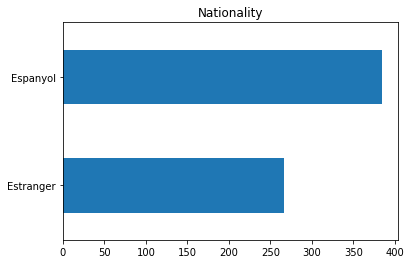

In [6]:
# data distribution by nationality

_ = df['V2_estranger'].value_counts(ascending=True).plot(kind='barh', title='Nationality')

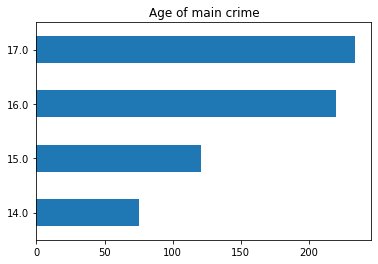

In [7]:
# data distribution by age

_ = df['V8_edat_fet'].value_counts(ascending=True).plot(kind='barh', title='Age of main crime')

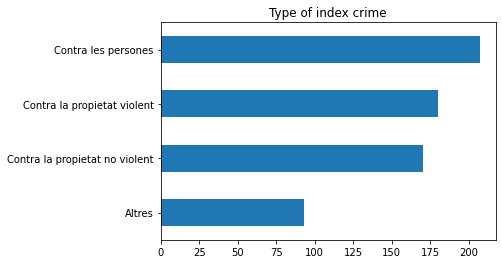

In [8]:
# data distribution by type of index crime

_ = df['V15_fet_agrupat'].value_counts(ascending=True).plot(kind='barh', title='Type of index crime')

## SAVRY model (human assessment)

The column `V56_@R1_resum_risc_global_reverse` is an evaluation done by a professional expert (that can be low, moderate, or high), based on the results of SAVRY but **applying his/her own judgment independently of the obtained score**.

The expert rates each defendant as "low", "medium", or "high" risk. Ideally, defendants considered low risk should recidivate at a lower rate than defendants considered high risk.

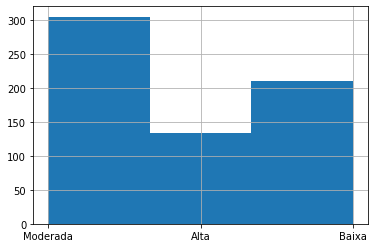

In [9]:
# human score distribution

hist = df['V56_@R1_resum_risc_global_reverse'].hist(bins=3)

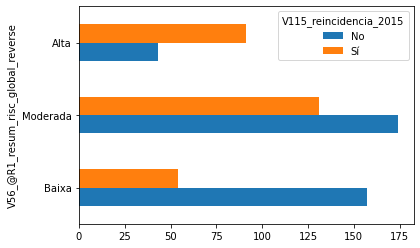

In [10]:
# human score distribution | recividism

human_ctable = pd.crosstab(df['V56_@R1_resum_risc_global_reverse'], df['V115_reincidencia_2015'])
human_ctable = human_ctable.reindex(index=["Baixa", "Moderada", "Alta"])
_ = human_ctable.plot(kind='barh')

In [11]:
# recividism rate per score

human_ctable["recidivism_rate"] = pd.Series(index=human_ctable.index, dtype='float')
for index, row in human_ctable.iterrows():
    recidivism_rate =row["Sí"] / (row["Sí"] + row["No"])
    human_ctable.at[index, "recidivism_rate"] = recidivism_rate
    
human_ctable

V115_reincidencia_2015              No   Sí  recidivism_rate
V56_@R1_resum_risc_global_reverse                           
Baixa                              157   54         0.255924
Moderada                           174  131         0.429508
Alta                                43   91         0.679104

### Baseline model

Our baseline prediction can be based on the column `V60_SAVRY_total_score`, which contains a sum of scores in the risk items of SAVRY. The max value of this sum is 40.

In [12]:
scores_recidivists = df[df["V115_reincidencia_2015"]=='Sí']["V60_SAVRY_total_score"].values
scores_non_recidivists = df[df["V115_reincidencia_2015"]=='No']["V60_SAVRY_total_score"].values

In [13]:
def compare_histograms(scores1, scores2, title, label1='Recidivists', label2='Non recidivists'):
    plt.figure(figsize=(10,6))
    plt.hist(scores1, histtype='step', label=label1, density=True, color='red')
    plt.hist(scores2, histtype='step', label=label2, density=True, color='blue')
    plt.legend(loc='upper right', fontsize='x-large')
    plt.ylabel('Probability')
    plt.xlabel(title)
    plt.show()

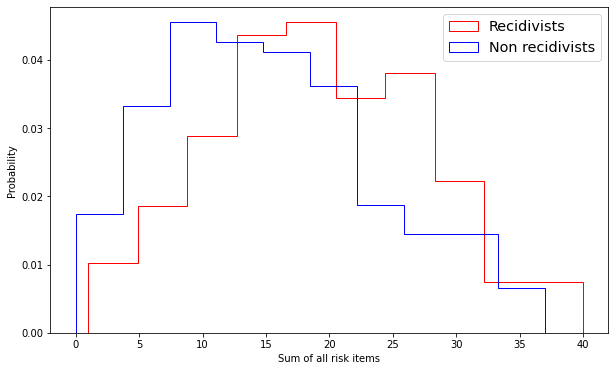

In [14]:
## baselin score distribution

compare_histograms(scores_recidivists, scores_non_recidivists, 'Sum of all risk items')

In [15]:
def draw_roc_curve( ground_truth, predictions, pos_label="Sí"):
    fpr, tpr, thresholds = roc_curve(ground_truth, predictions, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right", fontsize='x-large')
    plt.show()
    return roc_auc

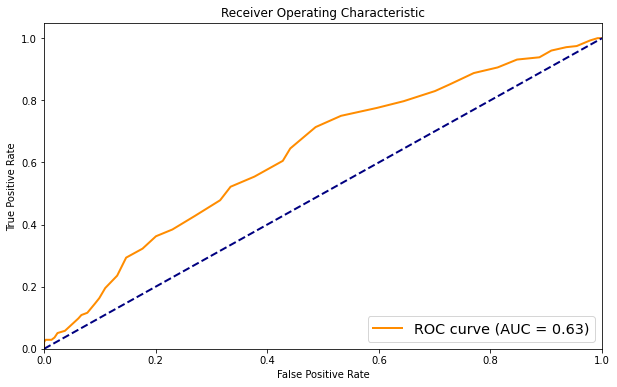

In [16]:
# Evaluation (ROC curve) of the baseline prediction

_ = draw_roc_curve(df["V115_reincidencia_2015"].values, df["V60_SAVRY_total_score"].values)

## Modeling recidivism using logistic regression

Logistic regression is a simple yet effective classification model for this problem.

In all cases above we will use the same training/testing split, which is done randomly, keeping 1/3 of the data for testing. You can repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [17]:
train, test = train_test_split(df, test_size=0.33)

### Modeling recidivism (24 risk factors)

Now we model recidivism by using the 24 risk factors in SAVRY.

Note that the performance depends on the training/testing split which is done randomly, keeping 1/3 of the data for testing. Repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [18]:
risk_factor_columns = list(df.columns)[70:94]

train_X = pd.get_dummies(train[risk_factor_columns])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[risk_factor_columns])
test_y = test["V115_reincidencia_2015"]

In [19]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [20]:
pred24_y = model.predict_proba(test_X)[:,1]
pred24_recidivists = pred24_y[test_y == 'Sí']
pred24_non_recidivists = pred24_y[test_y == 'No']

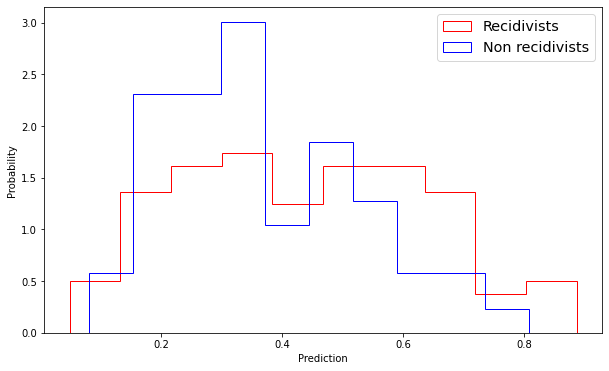

In [21]:
compare_histograms(pred24_recidivists, pred24_non_recidivists, 'Prediction')

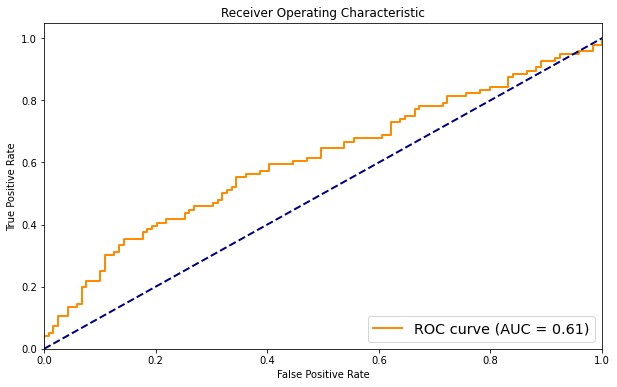

In [22]:
_ = draw_roc_curve(test_y, pred24_y)

### Modeling recidivism (personal history factors)

Next we use demographic factors: gender and nationality, as well as criminal history factors such as the age of commission of the index crime and its type, as well as whether the juvenile defendant has criminal records.

In [23]:
demographic_columns = ["V1_sexe", 
                       "V2_estranger", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents",
                       "V15_fet_agrupat", 
                       "V16_fet_violencia"]
                       
train_X = pd.get_dummies(train[demographic_columns])
train_y = train["V115_reincidencia_2015"]

test_X =  pd.get_dummies(test[demographic_columns])
test_y = test["V115_reincidencia_2015"]

In [24]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [25]:
predPH_y = model.predict_proba(test_X)[:,1]
predPH_recidivists = predPH_y[test_y == 'Sí']
predPH_non_recidivists = predPH_y[test_y == 'No']

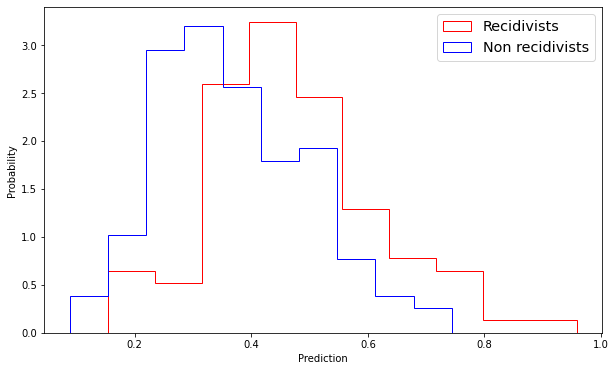

In [26]:
compare_histograms(predPH_recidivists, predPH_non_recidivists, 'Prediction')

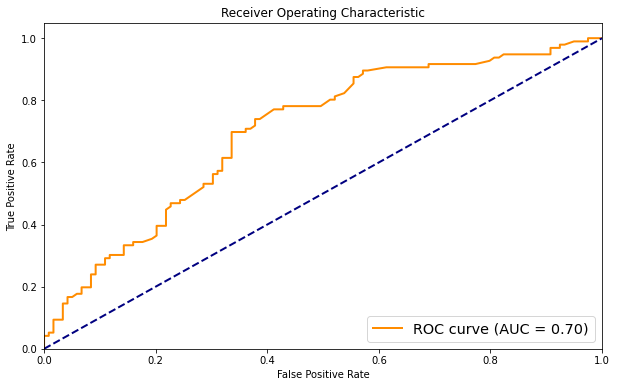

In [27]:
_ = draw_roc_curve(test_y, predPH_y)

### Modeling recidivism (personal history + 24 risk factors + 6 protective factors)

We now add to the above 6 "protective" or positive factors that are associated with a low risk.

In [28]:
protective_factor_columns = ["V89_@P1_impicacio_prosocial", 
                             "V90_@P2_suport_social_fort",
                             "V91_@P3_forta_vinculacio_adult_prosocial", 
                             "V92_@P4_actitud_positiva_intervencions_autoritat",
                             "V93_@P5_fort_compromis_escola_treball", 
                             "V94_@P6_perseverança_tret_personalitat"]

factors = demographic_columns + risk_factor_columns + protective_factor_columns

train_X = pd.get_dummies(train[factors])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[factors])
test_y = test["V115_reincidencia_2015"]

In [29]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [30]:
predALL_y = model.predict_proba(test_X)[:,1]
predALL_recidivists = predALL_y[test_y == 'Sí']
predALL_non_recidivists = predALL_y[test_y == 'No']

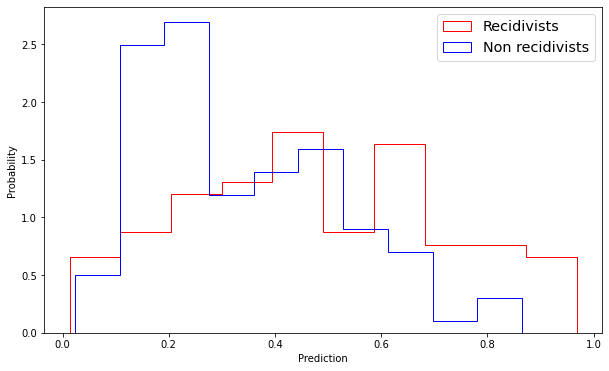

In [31]:
compare_histograms(predALL_recidivists, predALL_non_recidivists, 'Prediction')

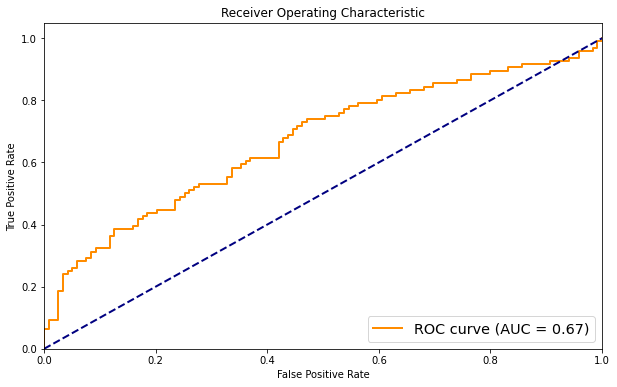

In [32]:
_ = draw_roc_curve(test_y, predALL_y)

# Recidivism and fairness
We remark that fairness is not necessarily that people in different groups obtain the same outcomes. For instance, in this dataset, women recidivate at about half the rate as men, and foreigners at a higher rate than nationals.

In [33]:
recidivism_by_gender = pd.crosstab(df["V115_reincidencia_2015"], df["V1_sexe"])
recidivism_by_gender['Dona'] = recidivism_by_gender['Dona'] / recidivism_by_gender['Dona'].sum()
recidivism_by_gender['Home'] = recidivism_by_gender['Home'] / recidivism_by_gender['Home'].sum()
recidivism_by_gender

V1_sexe                     Dona      Home
V115_reincidencia_2015                    
No                      0.759494  0.549912
Sí                      0.240506  0.450088

In [34]:
recidivism_by_nationality = pd.crosstab(df["V115_reincidencia_2015"], df["V2_estranger"])
recidivism_by_nationality['Espanyol'] = recidivism_by_nationality['Espanyol'] / recidivism_by_nationality['Espanyol'].sum()
recidivism_by_nationality['Estranger'] = recidivism_by_nationality['Estranger'] / recidivism_by_nationality['Estranger'].sum()
recidivism_by_nationality

V2_estranger            Espanyol  Estranger
V115_reincidencia_2015                     
No                      0.632812   0.492481
Sí                      0.367188   0.507519

# Fairness as **equality of error rates**

We can look at fairness as **equality of error rates**.

## Professional (human expert) recidivism prediction and fairness

We consider people who did not recidivate, in particular, look at those who were given a "high" risk by the expert.

In [35]:
non_recidivists = df[df["V115_reincidencia_2015"] == 'No']
non_recidivists_expert_by_gender = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V1_sexe"])
non_recidivists_expert_by_gender.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_gender["Home"] = non_recidivists_expert_by_gender["Home"] / non_recidivists_expert_by_gender["Home"].sum()
non_recidivists_expert_by_gender["Dona"] = non_recidivists_expert_by_gender["Dona"] / non_recidivists_expert_by_gender["Dona"].sum()
non_recidivists_expert_by_gender

V1_sexe                                Dona      Home
V56_@R1_resum_risc_global_reverse                    
Alta                               0.116667  0.114650
Baixa                              0.433333  0.417197
Moderada                           0.450000  0.468153

In [36]:
non_recidivists_expert_by_nationality = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V2_estranger"])
non_recidivists_expert_by_nationality.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_nationality["Espanyol"] = non_recidivists_expert_by_nationality["Espanyol"] / non_recidivists_expert_by_nationality["Espanyol"].sum()
non_recidivists_expert_by_nationality["Estranger"] = non_recidivists_expert_by_nationality["Estranger"] / non_recidivists_expert_by_nationality["Estranger"].sum()
non_recidivists_expert_by_nationality

V2_estranger                       Espanyol  Estranger
V56_@R1_resum_risc_global_reverse                     
Alta                               0.106996   0.129771
Baixa                              0.423868   0.412214
Moderada                           0.469136   0.458015

## Overall SAVRY score and fairness

In [37]:
scores_men_non_recidivists = df[(df["V115_reincidencia_2015"]=='Sí') &
                                      (df["V1_sexe"]=='Home')]["V60_SAVRY_total_score"].values
scores_women_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                       (df["V1_sexe"]=='Dona')]["V60_SAVRY_total_score"].values

print("Average SAVRY score of men non-recidivist: %.2f" %
      (scores_men_non_recidivists.sum() / len(scores_men_non_recidivists)))
       
print("Average SAVRY score of women non-recidivist: %.2f" % 
      (scores_women_non_recidivists.sum() / len(scores_women_non_recidivists)))

Average SAVRY score of men non-recidivist: 19.12
Average SAVRY score of women non-recidivist: 15.67


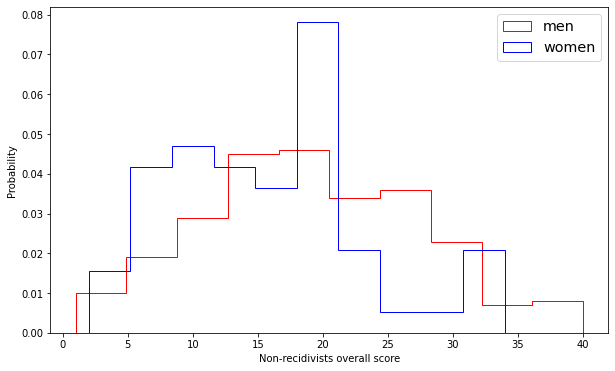

In [38]:
compare_histograms(scores_men_non_recidivists, scores_women_non_recidivists,
                   "Non-recidivists overall score",
                   label1="men", label2="women")

In [39]:
scores_nationals_non_recidivists = df[(df["V115_reincidencia_2015"]=='Sí') &
                                      (df["V2_estranger"]=='Espanyol')]["V60_SAVRY_total_score"].values
scores_foreigners_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                       (df["V2_estranger"]=='Estranger')]["V60_SAVRY_total_score"].values

print("Average SAVRY score of national non-recidivist: %.2f" %
      (scores_nationals_non_recidivists.sum() / len(scores_nationals_non_recidivists)))
       
print("Average SAVRY score of foreigner non-recidivist: %.2f" % 
      (scores_foreigners_non_recidivists.sum() / len(scores_foreigners_non_recidivists)))

Average SAVRY score of national non-recidivist: 18.89
Average SAVRY score of foreigner non-recidivist: 16.51


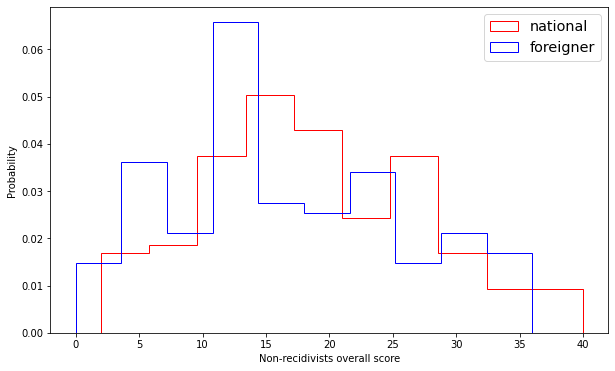

In [40]:
compare_histograms(scores_nationals_non_recidivists, scores_foreigners_non_recidivists,
                   "Non-recidivists overall score",
                   label1="national", label2="foreigner")

## Fairness using ML score

In [41]:
predPH_men_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
predPH_women_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]

print("Average predicted probability of men non-recidivist: %.2f" %
      (predPH_men_non_recidivists.sum() / len(predPH_men_non_recidivists)))
       
print("Average predicted probability of women non-recidivist: %.2f" % 
      (predPH_women_non_recidivists.sum() / len(predPH_women_non_recidivists)))

Average predicted probability of men non-recidivist: 0.40
Average predicted probability of women non-recidivist: 0.23


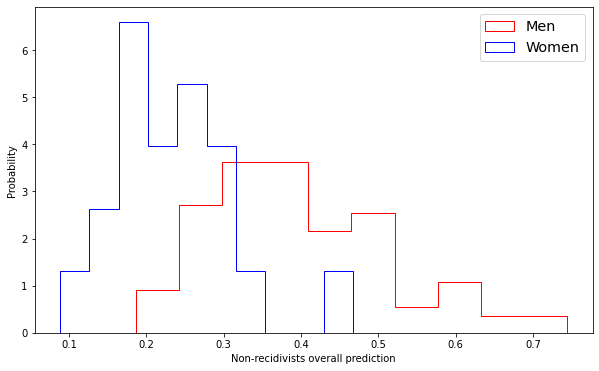

In [42]:
compare_histograms(predPH_men_non_recidivists, predPH_women_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Men", label2="Women")

In [43]:
predPH_nationals_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
predPH_foreigners_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]

print("Average predicted probability of national non-recidivist: %.2f" %
      (predPH_nationals_non_recidivists.sum() / len(predPH_nationals_non_recidivists)))
       
print("Average predicted probability of foreigner non-recidivist: %.2f" % 
      (predPH_foreigners_non_recidivists.sum() / len(predPH_foreigners_non_recidivists)))

Average predicted probability of national non-recidivist: 0.33
Average predicted probability of foreigner non-recidivist: 0.45


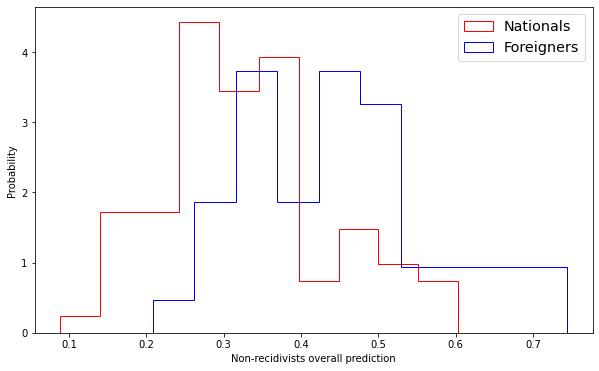

In [44]:
compare_histograms(predPH_nationals_non_recidivists, predPH_foreigners_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Nationals", label2="Foreigners")

# Exercise 1

1. Use different machine learning models (SVM, Random Forests, etc.) to check if you can increase the performance of the logistic regression model. 
2. Check if they satisfy the proposed fairness criteria. 
3. Compare several fairness criteria, such as Demographic Parity, Equal Opportunity, Equalized Odds, and Conditional Demographic Parity. 

### Questions (justify your answers)

1. Is there a method that can achieve better predictive power than human experts? 


2. Is this method better than human experts in terms of fairness?


3. Which is the most suited fairness criterium for this problem? Why?


4. What are your conclusion about the use of a ML model to predict recividism?



## Solution Exercise 1

### 1. Use different machine learning models (SVM, Random Forests, etc.) to check if you can increase the performance of the logistic regression model. 

In [45]:
#import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import Matern
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier


In [46]:
# prepare configuration for cross validation test harness
seed = 123
# prepare models
models = []
models.append(('LR', LogisticRegression(solver='liblinear')))
models.append(('LDA', LinearDiscriminantAnalysis()))
#models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(probability=True)))
models.append(('RF', RandomForestClassifier()))
models.append(('GP', GaussianProcessClassifier(kernel=Matern())))
models.append(('AdaB', AdaBoostClassifier()))
models.append(('SGD', SGDClassifier(loss='log_loss')))

In [47]:
train, test = train_test_split(df, test_size=0.33)

train_X = pd.get_dummies(train[factors])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[factors])
test_y = test["V115_reincidencia_2015"]

#### Cross validation over the different models:

In [48]:
## No splitting because of the cross validation:

full_X = pd.get_dummies(df[factors])
full_y = df["V115_reincidencia_2015"]

In [49]:
full_X

V8_edat_fet  V20_nombre_antecedents  V1_sexe_Dona  V1_sexe_Home  \
0            15.0                     1.0             0             1   
1            14.0                     1.0             1             0   
2            15.0                     4.0             0             1   
3            14.0                     7.0             0             1   
4            17.0                     6.0             0             1   
...           ...                     ...           ...           ...   
1390         17.0                     1.0             0             1   
1391         16.0                     2.0             0             1   
1392         15.0                     1.0             0             1   
1393         17.0                     1.0             0             1   
1394         17.0                     9.0             0             1   

      V2_estranger_Espanyol  V2_estranger_Estranger  V15_fet_agrupat_Altres  \
0                         1                       0                       0   
1                         1                       0                       0   
2                         0                       1                       0   
3                         0                       1                       0   
4                         1                       0                       0   
...                     ...                     ...                     ...   
1390                      1                       0                       1   
1391                      1                       0                       1   
1392                      1                       0                       1   
1393                      0                       1                       1   
1394                      1                       0                       1   

      V15_fet_agrupat_Contra la propietat no violent  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   
...                                              ...   
1390                                               0   
1391                                               0   
1392                                               0   
1393                                               0   
1394                                               0   

      V15_fet_agrupat_Contra la propietat violent  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   
...                                           ...   
1390                                            0   
1391                                            0   
1392                                            0   
1393                                            0   
1394                                            0   

      V15_fet_agrupat_Contra les persones  ...  \
0                                       1  ...   
1                                       1  ...   
2                                       1  ...   
3                                       1  ...   
4                                       1  ...   
...                                   ...  ...   
1390                                    0  ...   
1391                                    0  ...   
1392                                    0  ...   
1393                                    0  ...   
1394                                    0  ...   

      V90_@P2_suport_social_fort_Absent  V90_@P2_suport_social_fort_Present  \
0                                     0                                   1   
1                                     1                                   0   
2                               

In [50]:
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    print('-----------------')
    print('Evaluating model:', name)
    
    kfold = model_selection.KFold(n_splits=10, random_state=seed, shuffle = True)
    cv_results = model_selection.cross_val_score(model, full_X, full_y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

-----------------
Evaluating model: LR
LR: 0.598462 (0.076754)
-----------------
Evaluating model: LDA
LDA: 0.607692 (0.074500)
-----------------
Evaluating model: CART
CART: 0.509231 (0.071650)
-----------------
Evaluating model: NB
NB: 0.627692 (0.090704)
-----------------
Evaluating model: SVM
SVM: 0.635385 (0.073477)
-----------------
Evaluating model: RF
RF: 0.589231 (0.060393)
-----------------
Evaluating model: GP
GP: 0.641538 (0.074118)
-----------------
Evaluating model: AdaB
AdaB: 0.609231 (0.084321)
-----------------
Evaluating model: SGD
SGD: 0.578462 (0.073202)


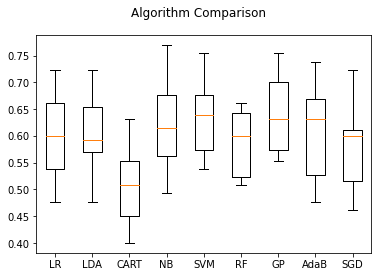

In [51]:
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

By studying the results obtained from the cross validation, taking into account the `accuracy score` we can see that the Gaussian Process provide the most concise and successful results, followed by the AdaBoost or the SVM model, regarding the Box-Plot algorithm which allows us to compare the different fitted models in order to study the distribution of the results obained. 

Let's now see how these models would perform when considering the AUC metrics and the splitting proportions considered on the first approach over this dataset:

#### Representation of the results in terms of the AUC metrics

In [52]:
probabilities = {}

for name, model in models:
    print('Evaluating model:', name)
    model.fit(train_X, train_y)
    probabilities[name] = model.predict_proba(test_X)[:,1] #store the probability of recividism


Evaluating model: LR
Evaluating model: LDA
Evaluating model: CART
Evaluating model: NB
Evaluating model: SVM
Evaluating model: RF
Evaluating model: GP
Evaluating model: AdaB
Evaluating model: SGD


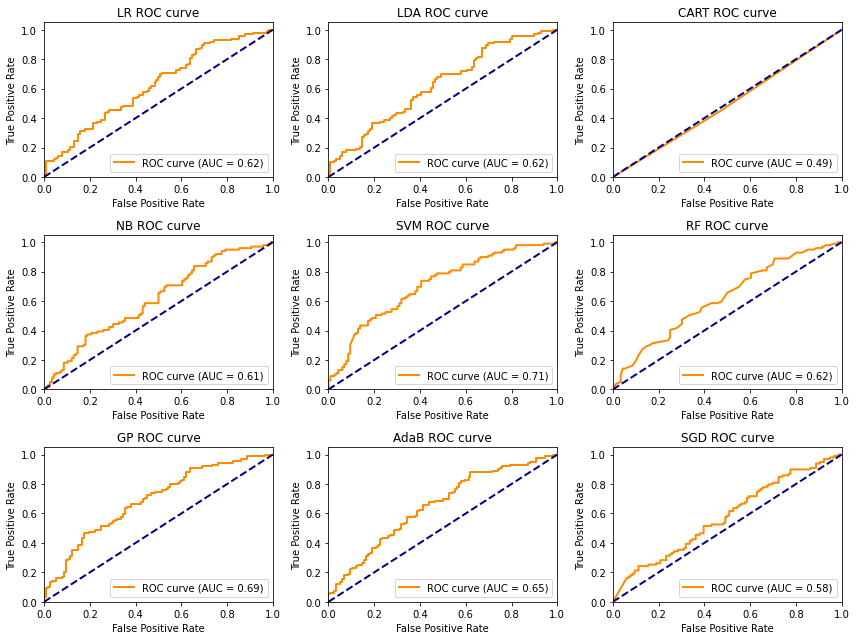

In [53]:
plt.figure(figsize=(12,9))
for i in range(1,10):
    fpr, tpr, thresholds = roc_curve(test_y, probabilities[names[i-1]], pos_label="Sí")
    roc_auc = auc(fpr, tpr)
    plt.subplot(int(str(33)+str(i)))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(names[i-1]+" ROC curve")
    plt.legend(loc="lower right")
    plt.tight_layout()
plt.show()

Observe that for this splitting of the dataset, and taking into account the AUC metrics, the model that best performs is the Gaussian Process, which is consistent with the results observed on the Cross Validation (0.69). The Support Vector Machine models also perform providing satisfactory AUC value (0.71), improving the performance of the original Logistic Regression. 

### 2. Check if they satisfy the proposed fairness criteria. 

On the following studies I may consider the Gaussian Process, as well as the SVM, in order to check for the ethical implications and fairness criterias. 

We measure fairness by applying different definitions of fairness. Most of the definitions involve splitting the population into privileged and unprivileged groups. We will see that the best metrics show who has benefitted from the model. Typically, a model’s prediction will either lead to a benefit or no benefit for a person. 

In our model, the target variable, `V115_reincidencia_2015` represents Recidivism (year 2015), encoded as `Y=0` for No and `Y=1` for Yes. Therefore, we want to study whether the model has a bias on predicting that someone has more probability of commiting recidivism by belonging ot a determinant sex. 


#### Accuracy

To start let’s discuss the accuracy and why it is not an ideal measure of fairness. We can base the accuracy calculation on the confusion matrix, which allows us to compare model predictions to the actual target variable. 

In order to conduct this study we may consider the model that got best AUC metrics, the Gaussian Process:

In [54]:
model1 = GaussianProcessClassifier(kernel=Matern())
model1.fit(train_X, train_y)
test_prob1 = model1.predict_proba(test_X)[:,1] #probability of recividate
test_yhat1 = model1.predict(test_X)

Recall the definition of the Confusion matrix, as given by the following Figure:


![fishy](CM.png)

Here, we use the default threshold provided by sklearn (0.5) to classify instances into recividists/non-recividists. 

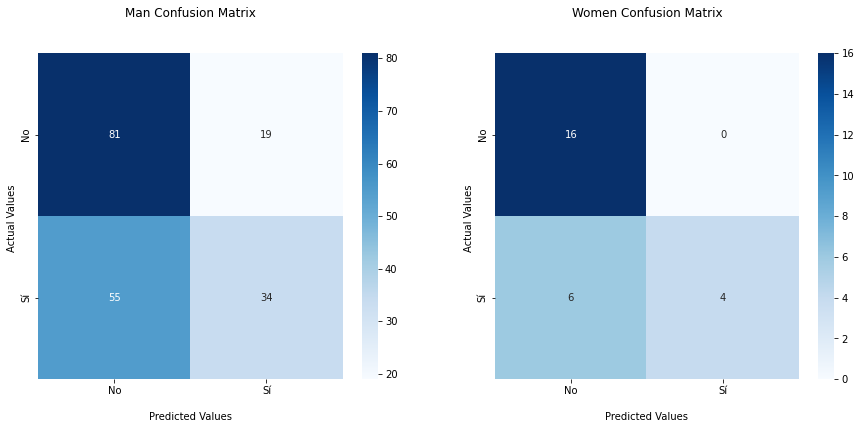

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


#Generate the confusion matrix
test_yhat_men =  test_yhat1[test_X["V1_sexe_Home"]==1]
test_y_men =  test_y[test_X["V1_sexe_Home"]==1]
cf_matrix_men = confusion_matrix(test_y_men, test_yhat_men)

test_yhat_women =  test_yhat1[test_X["V1_sexe_Dona"]==1]
test_y_women =  test_y[test_X["V1_sexe_Dona"]==1]
cf_matrix_women = confusion_matrix(test_y_women, test_yhat_women)

fig, ax = plt.subplots(1,2, figsize=(15, 6))

sns.heatmap(cf_matrix_men, annot=True, cmap='Blues', ax = ax[0])

ax[0].set_title('Man Confusion Matrix\n\n');
ax[0].set_xlabel('\nPredicted Values')
ax[0].set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax[0].xaxis.set_ticklabels(['No','Sí'])
ax[0].yaxis.set_ticklabels(['No','Sí'])

sns.heatmap(cf_matrix_women, annot=True, cmap='Blues', ax = ax[1])

ax[1].set_title('Women Confusion Matrix\n\n');
ax[1].set_xlabel('\nPredicted Values')
ax[1].set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax[1].xaxis.set_ticklabels(['No','Sí'])
ax[1].yaxis.set_ticklabels(['No','Sí'])

## Display the visualization of the Confusion Matrix.
plt.show()

Recall that accuracy $= \frac{TN + TP}{N}$ where $N = TP + FP + FN + TP$ is the total. Therefore we can consider the accuracy of our model by protected feature, in this case, being the gender the corresponding feature. 

In [56]:
N = cf_matrix_men[0,0]+cf_matrix_men[1,1] + cf_matrix_men[0,1]+cf_matrix_men[1,0]
N_w = cf_matrix_women[0,0]+cf_matrix_women[1,1] + cf_matrix_women[0,1]+cf_matrix_women[1,0]
index = ["Men", "Women"]
##metrics = ["ACC_Si", "ACC_No"]
metrics = ['ACC']

'''
data = [ [[cf_matrix_men[0,0]+cf_matrix_men[1,1]]/N, 
        [cf_matrix_men[0,1]+cf_matrix_men[1,0]]/N],
        [[cf_matrix_women[0,0]+cf_matrix_women[1,1]]/N_w, 
        [cf_matrix_women[0,1]+cf_matrix_women[1,0]]/N_w] ]
'''
data = [ [[cf_matrix_men[0,0]+cf_matrix_men[1,1]]/N], 
        [[cf_matrix_women[0,0]+cf_matrix_women[1,1]]/N_w ] ]
display(pd.DataFrame(data, index=index, columns = metrics))

ACC
Men    [0.6084656084656085]
Women  [0.7692307692307693]

Notice that therefore, the accuracy on the predictions is highier for the unprivileged group on our model. These results may mislead to believe that the model is benefiting the unprivileged group. However let's consider different ways of studying the fairness of our model.  

#### Proposed Fairness Criteria

Consider the proposed Fairness Criteria, based on studying the **equality of error rates**. Let's consider the proposed model:

In [57]:
predPH_recidivists = test_prob1[test_y == 'Sí']
predPH_non_recidivists = test_prob1[test_y == 'No']

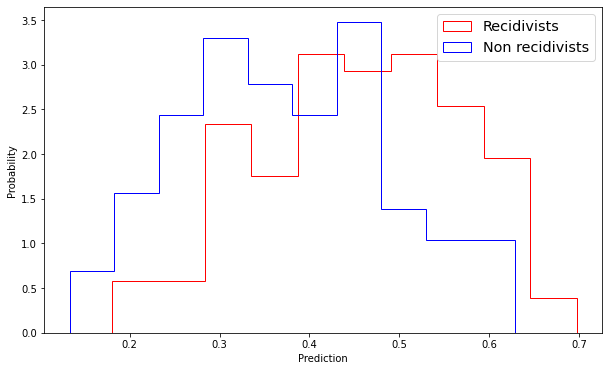

In [58]:
compare_histograms(predPH_recidivists, predPH_non_recidivists, 'Prediction')

In [59]:
predPH_men_non_recidivists = test_prob1[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
predPH_women_non_recidivists = test_prob1[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]

print("Average predicted probability of men non-recidivist: %.2f" %
      (predPH_men_non_recidivists.sum() / len(predPH_men_non_recidivists)))
       
print("Average predicted probability of women non-recidivist: %.2f" % 
      (predPH_women_non_recidivists.sum() / len(predPH_women_non_recidivists)))

Average predicted probability of men non-recidivist: 0.38
Average predicted probability of women non-recidivist: 0.34


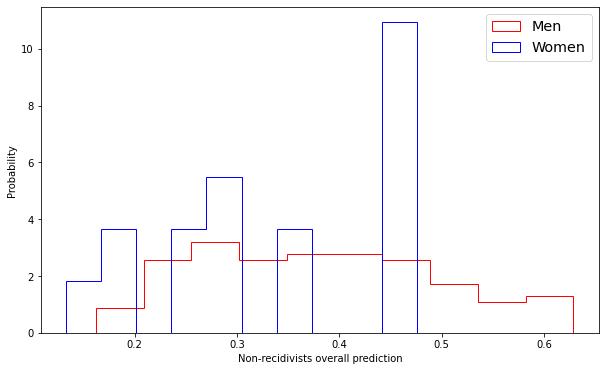

In [60]:
compare_histograms(predPH_men_non_recidivists, predPH_women_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Men", label2="Women")

Observe that the obtained results are way more balanced that the ones obtained for the Logistic regression (  0.41 for men non-recidivist, and 0.23 for women non-recidivist) which is quite an improvement on fairness on the predictions conducted. Observe however, that the model still has a bias on predicting non-recidivist. 

Let's conduct a similar study taking into account the **nationality type**:

In [61]:
predPH_nationals_non_recidivists = test_prob1[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
predPH_foreigners_non_recidivists = test_prob1[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]

print("Average predicted probability of national non-recidivist: %.2f" %
      (predPH_nationals_non_recidivists.sum() / len(predPH_nationals_non_recidivists)))
       
print("Average predicted probability of foreigner non-recidivist: %.2f" % 
      (predPH_foreigners_non_recidivists.sum() / len(predPH_foreigners_non_recidivists)))

Average predicted probability of national non-recidivist: 0.36
Average predicted probability of foreigner non-recidivist: 0.40


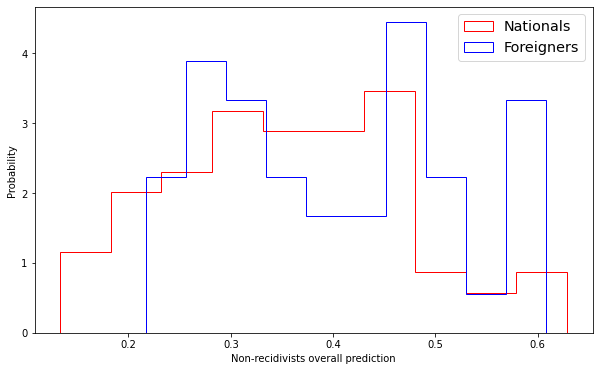

In [62]:
compare_histograms(predPH_nationals_non_recidivists, predPH_foreigners_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Nationals", label2="Foreigners")

Note that the model benefits the unprivileged group, which are the foreigners, this is it predicts more probability of being non-recividist for the foreigner than for the natioanl citizens. This result is similar to the one we got using the Logistic Regression (0.35 for national, 0.45 for the foreigner) although we have corrected some bias on this proposed new model. 

Let's study what would happen for **all the other models** considered above:

In [63]:
names[:-1]

['LR', 'LDA', 'CART', 'NB', 'SVM', 'RF', 'GP', 'AdaB']

In [99]:
probabilities[names[-1]]

array([2.86561899e-017, 6.53264147e-054, 2.63109092e-027, 2.54352041e-061,
       1.37177368e-051, 1.88662610e-073, 9.14233852e-088, 4.72728975e-032,
       4.89373206e-056, 2.82124236e-042, 2.50863170e-010, 1.34800725e-051,
       2.36927453e-075, 3.27079917e-060, 1.69681822e-071, 6.56187766e-060,
       5.18754820e-088, 3.64576213e-119, 1.35372183e-025, 1.12999646e-052,
       7.71907651e-033, 6.73515434e-096, 9.13918891e-033, 1.00792721e-079,
       5.34654663e-006, 4.82140397e-019, 4.11944786e-042, 6.39394183e-051,
       1.07692804e-039, 1.06627791e-053, 1.15537160e-069, 2.19400418e-057,
       2.52942508e-020, 1.33274962e-010, 2.40164486e-013, 2.80189773e-077,
       8.95468407e-035, 7.36296093e-065, 3.77397661e-039, 4.88521913e-046,
       6.08889147e-027, 1.72708810e-022, 2.36830107e-044, 3.51105916e-040,
       2.61488330e-034, 1.27273164e-043, 1.14121430e-052, 2.59673555e-031,
       8.21159617e-048, 6.60008012e-029, 1.64520900e-061, 2.30395164e-054,
       1.51686721e-004, 2

In [64]:
for name in names[:-1]:
    print('-----------')
    print('Fairness criteria for:', name)
    
    #model.fit(train_X, train_y)
    #fairness[name] = model.predict_proba(test_X)[:,1] #store the probability of recividism
    predPH_recidivists = probabilities[name][test_y == 'Sí']
    predPH_non_recidivists = probabilities[name][test_y == 'No']
    
    predPH_men_non_recidivists = probabilities[name][(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
    predPH_women_non_recidivists = probabilities[name][(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]

    print("Average predicted probability of men non-recidivist: %.2f" %
          (predPH_men_non_recidivists.sum() / len(predPH_men_non_recidivists)))

    print("Average predicted probability of women non-recidivist: %.2f" % 
          (predPH_women_non_recidivists.sum() / len(predPH_women_non_recidivists)))
    

-----------
Fairness criteria for: LR
Average predicted probability of men non-recidivist: 0.37
Average predicted probability of women non-recidivist: 0.17
-----------
Fairness criteria for: LDA
Average predicted probability of men non-recidivist: 0.37
Average predicted probability of women non-recidivist: 0.17
-----------
Fairness criteria for: CART
Average predicted probability of men non-recidivist: 0.47
Average predicted probability of women non-recidivist: 0.44
-----------
Fairness criteria for: NB
Average predicted probability of men non-recidivist: 0.40
Average predicted probability of women non-recidivist: 0.11
-----------
Fairness criteria for: SVM
Average predicted probability of men non-recidivist: 0.38
Average predicted probability of women non-recidivist: 0.33
-----------
Fairness criteria for: RF
Average predicted probability of men non-recidivist: 0.40
Average predicted probability of women non-recidivist: 0.33
-----------
Fairness criteria for: GP
Average predicted prob

Observe that the models that best verify the Fairness criteria of equality of rate of errors are the Gaussian Process, which is also the model taht provides the best AUC metrics, and the Ada Boost model. 

##### Equality of rate on nationality type:

In [66]:
for name in names:
    print('-----------')
    print('Fairness criteria for:', name)
    
    #model.fit(train_X, train_y)
    #fairness[name] = model.predict_proba(test_X)[:,1] #store the probability of recividism
    predPH_recidivists = probabilities[name][test_y == 'Sí']
    predPH_non_recidivists = probabilities[name][test_y == 'No']
    
    predPH_e_non_recidivists = probabilities[name][(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
    predPH_f_non_recidivists = probabilities[name][(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]

    print("Average predicted probability of nationals non-recidivist: %.2f" %
          (predPH_e_non_recidivists.sum() / len(predPH_e_non_recidivists)))

    print("Average predicted probability of foreigners non-recidivist: %.2f" % 
          (predPH_f_non_recidivists.sum() / len(predPH_f_non_recidivists)))
    

-----------
Fairness criteria for: LR
Average predicted probability of nationals non-recidivist: 0.31
Average predicted probability of foreigners non-recidivist: 0.38
-----------
Fairness criteria for: LDA
Average predicted probability of nationals non-recidivist: 0.32
Average predicted probability of foreigners non-recidivist: 0.38
-----------
Fairness criteria for: CART
Average predicted probability of nationals non-recidivist: 0.41
Average predicted probability of foreigners non-recidivist: 0.54
-----------
Fairness criteria for: NB
Average predicted probability of nationals non-recidivist: 0.34
Average predicted probability of foreigners non-recidivist: 0.39
-----------
Fairness criteria for: SVM
Average predicted probability of nationals non-recidivist: 0.36
Average predicted probability of foreigners non-recidivist: 0.39
-----------
Fairness criteria for: RF
Average predicted probability of nationals non-recidivist: 0.37
Average predicted probability of foreigners non-recidivist:

Observe that again the model that seems to present more fairness on the predictions is the Ada Boost model, this time presenting the same probability of non-recidivist for both groups of the society. Followed by the GP and the SVM model. 

Consider the previous plots for the **Ada Boost** model in orther to ensure that the computations are correct and to visualize what a balanced prediction (at least regarding the nationality type) would look like, according to this fairness criteria:

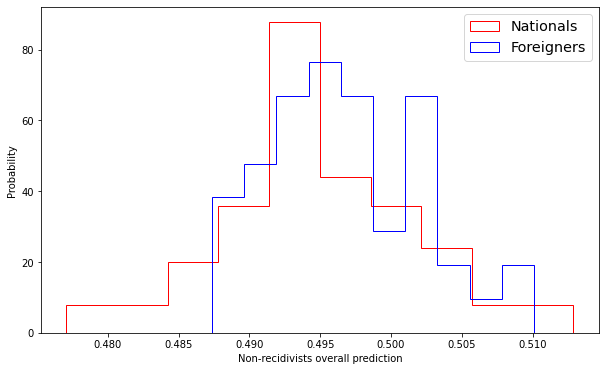

In [67]:
predPH_nationals_non_recidivists_AB = probabilities['AdaB'][(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
predPH_foreigners_non_recidivists_AB = probabilities['AdaB'][(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]

compare_histograms(predPH_nationals_non_recidivists_AB, predPH_foreigners_non_recidivists_AB,
                   "Non-recidivists overall prediction",
                   label1="Nationals", label2="Foreigners")

### 3. Compare several fairness criteria, such as Demographic Parity, Equal Opportunity, Equalized Odds, and Conditional Demographic Parity. 

We have seen how the different models predict and the results obtained following the proposed fairness criteria: the equality of error rate. We have also seen an insight on how we could use to accuracy of the model in order to get an idea on how the model is predicting and on the fairness it presents on the predictions. Let's now consider alternative fairness criteria. 

In order to do so, consider the Confusion matrix we have defined above, it will be usefull in order to define the following fairness criteria:

#### Demographic Parity 

Demographic disparity consists on studying the proportion of the predicted as belonging to the positive class that belongs to each group in comparison to the proportion of the negative class. This is, we actually have demographic disparity if 
$$
DD = P(X \in G| \hat{Y}=0) - P(X \in G| \hat{Y}=1)
$$
Clearly, by Bayes' formula we have $P(X \in G| \hat{Y}=1) = \frac{P(X \in G, \hat{Y}=1)}{P(\hat{Y}=1)}$.

The alternative definition of Demographic Parity, which requires the outcome to be independent of the protected class:
$$P(\hat{Y}=1|X\in G) \sim P(\hat{Y}=1|X\in G')$$
Similarly: $P(\hat{Y}=1|X\in G) = \frac{P(\hat{Y}=1,X\in G)}{P( X\in G)}$


In [92]:
for name, model in  models:
    print("=================================================================")
    print("             Demographic parity for {}              ".format(name))
    print("=================================================================")
    model.fit(train_X, train_y)
    test_prob = model.predict_proba(test_X)[:,1] #probability of recividate
    test_yhat = model.predict(test_X)

    P_men_Y0 = len(test_yhat[(test_X["V1_sexe_Home"]==1)&(test_yhat=='Sí')])/len(test_yhat[(test_yhat=='Sí')])
    P_men_Y1 = len(test_yhat[(test_X["V1_sexe_Home"]==1)&(test_yhat=='No')])/len(test_yhat[(test_yhat=='No')])
    
    P_women_Y0 = len(test_yhat[(test_X["V1_sexe_Dona"]==1)&(test_yhat=='Sí')])/len(test_yhat[(test_yhat=='Sí')])
    P_women_Y1 = len(test_yhat[(test_X["V1_sexe_Dona"]==1)&(test_yhat=='No')])/len(test_yhat[(test_yhat=='No')])
    
    P_Y0_men = len(test_yhat[(test_X["V1_sexe_Home"]==1)&(test_yhat=='Sí')])/len(test_yhat[(test_X["V1_sexe_Home"]==1)])
    P_Y1_men = len(test_yhat[(test_X["V1_sexe_Home"]==1)&(test_yhat=='No')])/len(test_yhat[(test_X["V1_sexe_Home"]==1)])
    
    P_Y0_women = len(test_yhat[(test_X["V1_sexe_Dona"]==1)&(test_yhat=='Sí')])/len(test_yhat[(test_X["V1_sexe_Dona"]==1)])
    P_Y1_women = len(test_yhat[(test_X["V1_sexe_Dona"]==1)&(test_yhat=='No')])/len(test_yhat[(test_X["V1_sexe_Dona"]==1)])
    
    ## We should either have 
    ## DD_men = P_men_Y0 - P_men_Y1 \sim 0
    ## DD_women = P_women_Y0 - P_women_Y0 \sim 0
    
    
    ## or either:
    ## P_Y0_men = P_Y0_women
    ## P_Y1_men = P_Y1_women
    
    
    index = ["Men", "Women", '_Men', '_Women' ]
    metrics = ["Y0_Sí", "Y1_No", 'Ratio']
    data = [[P_men_Y0,P_men_Y1, P_men_Y0-P_men_Y1 ], [P_women_Y0,P_women_Y1, P_women_Y0-P_women_Y1],
           [P_Y0_men, P_Y1_men, P_Y0_men - P_Y0_women ], [P_Y0_women, P_Y1_women, P_Y1_men - P_Y1_women ] ]
    display(pd.DataFrame(data, index=index, columns = metrics))

             Demographic parity for LR              


Y0_Sí     Y1_No     Ratio
Men     1.000000  0.831169  0.168831
Women   0.000000  0.168831 -0.168831
_Men    0.322751  0.677249  0.322751
_Women  0.000000  1.000000 -0.322751

             Demographic parity for LDA              


Y0_Sí     Y1_No     Ratio
Men     1.000000  0.825503  0.174497
Women   0.000000  0.174497 -0.174497
_Men    0.349206  0.650794  0.349206
_Women  0.000000  1.000000 -0.349206

             Demographic parity for CART              


Y0_Sí     Y1_No     Ratio
Men     0.915094  0.844037  0.071058
Women   0.084906  0.155963 -0.071058
_Men    0.513228  0.486772  0.167074
_Women  0.346154  0.653846 -0.167074

             Demographic parity for NB              


Y0_Sí     Y1_No     Ratio
Men     0.922222  0.848000  0.074222
Women   0.077778  0.152000 -0.074222
_Men    0.439153  0.560847  0.169923
_Women  0.269231  0.730769 -0.169923

             Demographic parity for SVM              


Y0_Sí     Y1_No     Ratio
Men     0.885714  0.877778  0.007937
Women   0.114286  0.122222 -0.007937
_Men    0.164021  0.835979  0.010175
_Women  0.153846  0.846154 -0.010175

             Demographic parity for RF              


Y0_Sí     Y1_No     Ratio
Men     0.926471  0.857143  0.069328
Women   0.073529  0.142857 -0.069328
_Men    0.333333  0.666667  0.141026
_Women  0.192308  0.807692 -0.141026

             Demographic parity for GP              


Y0_Sí     Y1_No     Ratio
Men     0.929825  0.860759  0.069065
Women   0.070175  0.139241 -0.069065
_Men    0.280423  0.719577  0.126577
_Women  0.153846  0.846154 -0.126577

             Demographic parity for AdaB              


Y0_Sí     Y1_No     Ratio
Men     0.970149  0.837838  0.132311
Women   0.029851  0.162162 -0.132311
_Men    0.343915  0.656085  0.266992
_Women  0.076923  0.923077 -0.266992

             Demographic parity for SGD              


Y0_Sí     Y1_No     Ratio
Men     0.969231  0.840000  0.129231
Women   0.030769  0.160000 -0.129231
_Men    0.333333  0.666667  0.256410
_Women  0.076923  0.923077 -0.256410

Observe therefore, that actually what is preserving is the quantity `P_men_Y0 - P_men_Y1 = P_women_Y0 - P_women_Y1`, where `P_men_Y0` denotes the conditional probability of being in the group of men, given that the prediction was 0, `Sí`. Similarly, we have `P_Y0_men - P_Y0_women = P_Y1_men - P_Y1_women`. Therefore, we could say that even though we do not have $DD = 0$ regarding any modenl (although they are all close to 0) we have that the relation between the probabilities of being in one or the other group conditioned to the predicted output follow similary probability distributions. 

Demographic Parity states that the proportion of each segment of a protected class (e.g. gender) should receive the positive outcome at equal rates. With regard to the confusion matrix, we require the Positive Rate (PR) to be the same for each segment of the protected class, i.e. $PR(G) = PR(G')$. 

This metrics will be defined as the total predicted positives over the total predictions, this is $PR(G) = \frac{FP + TP}{N}$, where $N=TP + FP + TN + FN$. The corresponding values will be presented on the following table (present on the next section of the exercise).

Using this metrics we see that the closer model to demographic parity is the SVM, which is also deduced by the results obtained on the previous table (the values are the closest to 0, under some threshold could even be considered 0). On the following tables in fact both features are studied, gender and nationality. And the result is similar for both classifications, we obtain closer to 1 ratios for the SVM model in both cases. 

Full study taking into account also the nationality type is present on the last section of this Exercise (so the information is not unnecesarily repeated)

In [127]:
#pip install fairlearn

     |████████████████████████████████| 235 kB 4.5 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [72]:
#from fairlearn.metrics import demographic_parity_ratio, equalized_odds_ratio
#from fairlearn.reductions import DemographicParity

#### Equal opportunity

This is equivalent to the true positive rate. By definition, we are asking that 
$$
P(\hat{Y} = 1 | Y = 1, X \in G) = P(\hat{Y} = 1 | Y = 1, X \in G') 
$$
where 1 is the positive prediction (in our case in fact, the positive prediction may be 0, equivallent to non-recividism, and $G'$ is the unprivileged group, in our case may be women or foreinger, depending on the feature we are looking at. 

Therefore, in terms of the confusion matrix, in order to compute the true positive rate, TPR, we may follow the expression
$$
TPR = \frac{TP}{TP + FN}
$$
The denominator is the number of actual positives. The numerator is the number of correctly predicted positives. In other words, TPR is the percentage of actual positives that were correctly predicted as positive. In this case, we are assuming that the positive prediction actually leads to some benefit, in this case the benefitial prediction would be non-recividism, so that in such case less strictive measures would be taken onto the individual. Hence, the positive prediction will be `No`, while the negative prediction is `Sí`. 

This means the denominator can be seen as the number of people who should benefit from the model. The numerator is the number who should and have benefited. So TPR can be interpreted as the percentage of people who have rightfully benefitted from the model.

In [87]:
for name, model in  models:
    print("=================================================================")
    print("              Fairness metrics for {}              ".format(name))
    print("=================================================================")
    model.fit(train_X, train_y)
    test_prob = model.predict_proba(test_X)[:,1] #probability of recividate
    test_yhat = model.predict(test_X)

    FN = len(test_yhat[(test_X["V1_sexe_Home"]==1)&(test_y=='No')&(test_yhat=='Sí')])
    TN = len(test_yhat[(test_X["V1_sexe_Home"]==1)&(test_y=='Sí')&(test_yhat=='Sí')])
    FP = len(test_yhat[(test_X["V1_sexe_Home"]==1)&(test_y=='Sí')&(test_yhat=='No')])
    TP = len(test_yhat[(test_X["V1_sexe_Home"]==1)&(test_y=='No')&(test_yhat=='No')])

    cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)
    TPR_man = TP / (TP+FN)
    FPR_man = FP / (FP+TN)
    PR_man = (FP + TP)/(FP+TP+FN+TN)
    
    FNR_man = FN / (FN+TP)


    FN = len(test_yhat[(test_X["V1_sexe_Dona"]==1)&(test_y=='No')&(test_yhat=='Sí')])
    TN = len(test_yhat[(test_X["V1_sexe_Dona"]==1)&(test_y=='Sí')&(test_yhat=='Sí')])
    FP = len(test_yhat[(test_X["V1_sexe_Dona"]==1)&(test_y=='Sí')&(test_yhat=='No')])
    TP = len(test_yhat[(test_X["V1_sexe_Dona"]==1)&(test_y=='No')&(test_yhat=='No')])

    cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)
    TPR_women = TP / (TP+FN)
    FPR_women = FP / (FP+TN)
    PR_women = (FP + TP)/(FP+TP+FN+TN)

    FNR_women = FN / (FN+TP)

    index = ["Men", "Women", 'Ratio' ]
    metrics = ["TPR", "FPR", 'PR', 'FNR']
    data = [[TPR_man,FPR_man, PR_man, FNR_man], [TPR_women, FPR_women, PR_women, FNR_women],
           [TPR_women/TPR_man, FPR_women/FPR_man , PR_women/PR_man, FNR_women/FNR_man ] ]
    display(pd.DataFrame(data, index=index, columns = metrics))

              Fairness metrics for LR              


TPR       FPR        PR   FNR
Men    0.750000  0.595506  0.677249  0.25
Women  1.000000  1.000000  1.000000  0.00
Ratio  1.333333  1.679245  1.476562  0.00

              Fairness metrics for LDA              


TPR       FPR        PR   FNR
Men    0.720000  0.573034  0.650794  0.28
Women  1.000000  1.000000  1.000000  0.00
Ratio  1.388889  1.745098  1.536585  0.00

              Fairness metrics for CART              


TPR       FPR        PR       FNR
Men    0.490000  0.539326  0.513228  0.510000
Women  0.687500  0.700000  0.692308  0.312500
Ratio  1.403061  1.297917  1.348929  0.612745

              Fairness metrics for NB              


TPR       FPR        PR     FNR
Men    0.600000  0.516854  0.560847  0.4000
Women  0.875000  0.500000  0.730769  0.1250
Ratio  1.458333  0.967391  1.302975  0.3125

              Fairness metrics for SVM              


TPR       FPR        PR   FNR
Men    0.890000  0.775281  0.835979  0.11
Women  1.000000  0.600000  0.846154  0.00
Ratio  1.123596  0.773913  1.012171  0.00

              Fairness metrics for RF              


TPR       FPR        PR   FNR
Men    0.720000  0.629213  0.677249  0.28
Women  1.000000  0.700000  0.884615  0.00
Ratio  1.388889  1.112500  1.306190  0.00

              Fairness metrics for GP              


TPR       FPR        PR   FNR
Men    0.810000  0.617978  0.719577  0.19
Women  1.000000  0.600000  0.846154  0.00
Ratio  1.234568  0.970909  1.175905  0.00

              Fairness metrics for AdaB              


TPR       FPR        PR   FNR
Men    0.740000  0.561798  0.656085  0.26
Women  1.000000  0.800000  0.923077  0.00
Ratio  1.351351  1.424000  1.406948  0.00

              Fairness metrics for SGD              


TPR       FPR        PR   FNR
Men    0.630000  0.494382  0.566138  0.37
Women  1.000000  0.800000  0.923077  0.00
Ratio  1.587302  1.618182  1.630482  0.00

The third row corresponds to the ratio between the unprivileged and the privileged groups. Note that this ratio is above 1 for ALL the models. Therefore, observe that the discrimination regarding the equality of oportunities is clearly present on **ALL** of the models considered, even the Ada Boost and the Gaussian Process, which until this study seemed to be the more unbiased models. Observe, nonetheless that the model that gets closer to a real equality of opportunity is the Random Forest, with a TRP of 0.73 for men, and 0.79 for women, and therefore a ratio of 1.07. This is, the model tends to predict as the benefited class (non-recivident) towards the unprivileged group (women). This suggests that a smaller percentage of the privileged group has rightfully benefitted from the model, i.e. smaller percentage of men were correctly predicted as non-recivident. 

Let's take a look ar what happends for the nationality type feature:

In [85]:
for name, model in models:
    print("=================================================================")
    print("              Equal opportunity for {}              ".format(name))
    print("=================================================================")
    model.fit(train_X, train_y)
    test_prob = model.predict_proba(test_X)[:,1] #probability of recividate
    test_yhat = model.predict(test_X)
    
    FN = len(test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='No')&(test_yhat=='Sí')])
    TN = len(test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='Sí')&(test_yhat=='Sí')])
    FP = len(test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='Sí')&(test_yhat=='No')])
    TP = len(test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='No')&(test_yhat=='No')])

    cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)
    TPR_spain = TP / (TP+FN)
    FPR_spain = FP / (FP+TN)
    PR_spain = (FP + TP)/(FP+TP+FN+TN)
    FNR_spain = FN / (FN+TP)


    FN = len(test_yhat[(test_X["V2_estranger_Estranger"]==1)&(test_y=='No')&(test_yhat=='Sí')])
    TN = len(test_yhat[(test_X["V2_estranger_Estranger"]==1)&(test_y=='Sí')&(test_yhat=='Sí')])
    FP = len(test_yhat[(test_X["V2_estranger_Estranger"]==1)&(test_y=='Sí')&(test_yhat=='No')])
    TP = len(test_yhat[(test_X["V2_estranger_Estranger"]==1)&(test_y=='No')&(test_yhat=='No')])

    cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)
    TPR_foreign = TP / (TP+FN)
    FPR_foreign = FP / (FP+TN)
    PR_foreign = (FP + TP)/(FP+TP+FN+TN)
    FNR_foreign = FN / (FN+TP)

    index = ["National", "Foreigner", "Ratio"]
    metrics = ["TPR", "FPR", 'PR', 'FNR']
    data = [[TPR_spain,FPR_spain, PR_spain, FNR_spain], [TPR_foreign, FPR_foreign, PR_foreign, FNR_foreign],
           [TPR_foreign/ TPR_spain , FPR_foreign/FPR_spain, PR_foreign/ PR_spain, FNR_foreign/FNR_spain]]
    display(pd.DataFrame(data, index=index, columns = metrics))

              Equal opportunity for LR              


TPR       FPR        PR       FNR
National   0.828571  0.740741  0.790323  0.171429
Foreigner  0.717391  0.511111  0.615385  0.282609
Ratio      0.865817  0.690000  0.778650  1.648551

              Equal opportunity for LDA              


TPR       FPR        PR       FNR
National   0.771429  0.722222  0.750000  0.228571
Foreigner  0.739130  0.488889  0.615385  0.260870
Ratio      0.958132  0.676923  0.820513  1.141304

              Equal opportunity for CART              


TPR       FPR        PR       FNR
National   0.585714  0.611111  0.596774  0.414286
Foreigner  0.391304  0.488889  0.439560  0.608696
Ratio      0.668081  0.800000  0.736561  1.469265

              Equal opportunity for NB              


TPR       FPR        PR       FNR
National   0.657143  0.592593  0.629032  0.342857
Foreigner  0.608696  0.422222  0.516484  0.391304
Ratio      0.926276  0.712500  0.821076  1.141304

              Equal opportunity for SVM              


TPR       FPR        PR       FNR
National   0.928571  0.796296  0.870968  0.071429
Foreigner  0.869565  0.711111  0.791209  0.130435
Ratio      0.936455  0.893023  0.908425  1.826087

              Equal opportunity for RF              


TPR       FPR        PR       FNR
National   0.857143  0.759259  0.814516  0.142857
Foreigner  0.673913  0.488889  0.582418  0.326087
Ratio      0.786232  0.643902  0.715047  2.282609

              Equal opportunity for GP              


TPR       FPR        PR       FNR
National   0.885714  0.759259  0.830645  0.114286
Foreigner  0.760870  0.444444  0.604396  0.239130
Ratio      0.859046  0.585366  0.727622  2.092391

              Equal opportunity for AdaB              


TPR       FPR        PR       FNR
National   0.814286  0.666667  0.750000  0.185714
Foreigner  0.717391  0.488889  0.604396  0.282609
Ratio      0.881007  0.733333  0.805861  1.521739

              Equal opportunity for SGD              


TPR       FPR        PR       FNR
National   0.900000  0.870370  0.887097  0.100000
Foreigner  0.956522  0.733333  0.846154  0.043478
Ratio      1.062802  0.842553  0.953846  0.434783

Observe that the results obtained for this feature are nearly opposite from the case of the gender bias. In this case, in general the ratio of the previleged over the unprivileged class is bellow 1, except for some exceptions (CART model). This is, there is a smaller percentage of the unprivileged group (in this case the foreingers) that has rightfully benefitted from the model. 

For the Gaussian Process and for the Ada Boost, the models that seemed to get the more fair or balanced predictions on the previous experiments, we get a closer to 0.7 ratio between the TPR of the privileged over the unprivileged groups. Therefore, there is a bias on discriminating the foreingers by these models, and tending to predict that they will be recidivit more probably than national citizens. 

Therefore, regarding this metrics, we see that there is not equality of opportunities regarding the nationalitiy type nor the gender. However, the discrimination is different. On the one hand, it seems that the models tend to benefit the unprivileged class when studying the gender (this is, being more prone to predict that the men will be reicivident than the women). On the other hand, the discrimination regarding the nationality type seems to benefit the privileged class, this is the national class is less probably predicted to exhibit recividism.


#### Equalized odds

By definition, we have a model with equalized odds regarding the different groups $G, G'$ of a feature when we have
\begin{align*}
P(\hat{Y} = 1 | Y = 1, X \in G) &= P(\hat{Y} = 1 | Y = 1, X \in G') 
P(\hat{Y} = 1 | Y = 0, X \in G) &= P(\hat{Y} = 1 | Y = 0, X \in G') 
\end{align*}
where 1 is the positive prediction (in our case in fact, the positive prediction may be 0, equivallent to non-recividism), and $G'$ is the unprivileged group, in our case may be women or foreinger, depending on the feature we are looking at. In this case in addition to the True positive rate, we also have to study the false positive rate, which is defined as follows
$$
FPR = \frac{FP}{FP + TN}
$$
In this case, the denominator is the number of actual negatives. This means the TPR is the percentage of actual negatives incorrectly predicted as positive. This can be interpreted as the percentage of people who have wrongfully benefited from the model.

The results when evaluating this metrics on our different models are presented on the previous tables. 

When studying the results obtained, we can see that there is still a bias on the gender, since all the ratios are above 1. Therefore, we have highier rates for the unprivileged group, which tells us that a highier percentage of the women has wrongfully benefitted from the model (was predicted as non-revident but did actually fall into recividism). 

We can start getting some conclusions, seems regardless of the models used, it seems that there is a strong bias towards being more prone to consider predict that men will exhibit recidivism than men. 



On the other, for the case of the nationality type we seem to have ratios closer to 1. This is, it does no seem like there is that benefit, of considering an inidvidual wrongfully classified as non-recividism because of their nationality. For example, for the GP model we get a ratio of 1.02. 

However, there are some models that again tend ti wrongfully benefit the privileged class (the foreigners), such as the Ada Boost, with a ratio of 0.89.  

#### Conditional Demographic parity

We can condition DD on attibutes that define a strata of subgroups on the dataset. 

Total number of predicted not recividists:
$$\hat{n}^{\bar{recid}} = \hat{n}^\bar{recid}_{G^+} + \hat{n}^\bar{recid}_{G^-}$$ 
Total number of predicted recividists:
$$\hat{n}^{recid} = \hat{n}^{recid}_{G^+} + \hat{n}^{recid}_{G^-}$$ 
Demographic disparity for group G^+:
$$DD_{G^+} = \frac{\hat{n}^\bar{recid}_{G^+}}{\hat{n}^{\bar{recid}}} - \frac{\hat{n}^{recid}_{G^+}}{\hat{n}^{recid}}$$
Conditional demographic disparity:
$$CDD = \frac{1}{n}*\sum_i n_i * DD_i$$ where $n$ is the total number of observations and $n_i$ is the number of observations per subgroup i.

The CDD metric gives a single measure for all of the disparities found in the subgroups defined by an attribute of a dataset by averaging them. **Positive values** indicate there is a demographic disparity as facet d or subgroup has a greater proportion of the rejected outcomes in the dataset than of the accepted outcomes. The higher the value the less favored the facet and the greater the disparity. **Negative values** indicate there is not a demographic disparity as facet d or subgroup has a larger proportion of the accepted outcomes in the dataset than of the rejected outcomes. The lower the value the more favored the facet.

In [78]:
for name, model in  models:
    print("=================================================================")
    print("             Cond Demographic parity for {}              ".format(name))
    print("=================================================================")
    model.fit(train_X, train_y)
    test_prob = model.predict_proba(test_X)[:,1] #probability of recividate
    test_yhat = model.predict(test_X)

    P_men_Y0 = len(test_yhat[(test_X["V1_sexe_Home"]==1)&(test_yhat=='Sí')])/len(test_yhat[(test_yhat=='Sí')])
    P_men_Y1 = len(test_yhat[(test_X["V1_sexe_Home"]==1)&(test_yhat=='No')])/len(test_yhat[(test_yhat=='No')])
    
    P_women_Y0 = len(test_yhat[(test_X["V1_sexe_Dona"]==1)&(test_yhat=='Sí')])/len(test_yhat[(test_yhat=='Sí')])
    P_women_Y1 = len(test_yhat[(test_X["V1_sexe_Dona"]==1)&(test_yhat=='No')])/len(test_yhat[(test_yhat=='No')])
    
    P_Y0_men = len(test_yhat[(test_X["V1_sexe_Home"]==1)&(test_yhat=='Sí')])/len(test_yhat[(test_X["V1_sexe_Home"]==1)])
    P_Y1_men = len(test_yhat[(test_X["V1_sexe_Home"]==1)&(test_yhat=='No')])/len(test_yhat[(test_X["V1_sexe_Home"]==1)])
    
    P_Y0_women = len(test_yhat[(test_X["V1_sexe_Dona"]==1)&(test_yhat=='Sí')])/len(test_yhat[(test_X["V1_sexe_Dona"]==1)])
    P_Y1_women = len(test_yhat[(test_X["V1_sexe_Dona"]==1)&(test_yhat=='No')])/len(test_yhat[(test_X["V1_sexe_Dona"]==1)])
    
    ## We should either have 
    DD_men = P_men_Y0 - P_men_Y1        #\sim 0
    DD_women = P_women_Y0 - P_women_Y0  #\sim 0
    
    
    
    ## or either:
    ## P_Y0_men = P_Y0_women
    ## P_Y1_men = P_Y1_women
    
    CDD = (len(test_yhat[(test_X["V1_sexe_Dona"]==1)]) * DD_women + len(test_yhat[(test_X["V1_sexe_Home"]==1)]) * DD_men)/len(test_yhat)
    
    index = ["Men", "Women", '_Men', '_Women' ]
    metrics = ["Y0_Sí", "Y1_No", 'Ratio']
    data = [[P_men_Y0,P_men_Y1, P_men_Y0-P_men_Y1 ], [P_women_Y0,P_women_Y1, P_women_Y0-P_women_Y1],
           [P_Y0_men, P_Y1_men, P_Y0_men - P_Y0_women ], [P_Y0_women, P_Y1_women, P_Y1_men - P_Y1_women ] ]
    display(pd.DataFrame(data, index=index, columns = metrics))
    print('Conditional Demographic Disparity:', CDD)

             Cond Demographic parity for LR              


Y0_Sí     Y1_No     Ratio
Men     1.000000  0.831169  0.168831
Women   0.000000  0.168831 -0.168831
_Men    0.322751  0.677249  0.322751
_Women  0.000000  1.000000 -0.322751

Conditional Demographic Disparity: 0.14841437632135301
             Cond Demographic parity for LDA              


Y0_Sí     Y1_No     Ratio
Men     1.000000  0.825503  0.174497
Women   0.000000  0.174497 -0.174497
_Men    0.349206  0.650794  0.349206
_Women  0.000000  1.000000 -0.349206

Conditional Demographic Disparity: 0.15339472452005615
             Cond Demographic parity for CART              


Y0_Sí     Y1_No     Ratio
Men     0.913462  0.846847  0.066615
Women   0.086538  0.153153 -0.066615
_Men    0.502646  0.497354  0.156492
_Women  0.346154  0.653846 -0.156492

Conditional Demographic Disparity: 0.05855896146593818
             Cond Demographic parity for NB              


Y0_Sí     Y1_No     Ratio
Men     0.922222  0.848000  0.074222
Women   0.077778  0.152000 -0.074222
_Men    0.439153  0.560847  0.169923
_Women  0.269231  0.730769 -0.169923

Conditional Demographic Disparity: 0.06524651162790704
             Cond Demographic parity for SVM              


Y0_Sí     Y1_No     Ratio
Men     0.885714  0.877778  0.007937
Women   0.114286  0.122222 -0.007937
_Men    0.164021  0.835979  0.010175
_Women  0.153846  0.846154 -0.010175

Conditional Demographic Disparity: 0.006976744186046487
             Cond Demographic parity for RF              


Y0_Sí     Y1_No     Ratio
Men     0.893939  0.872483  0.021456
Women   0.106061  0.127517 -0.021456
_Men    0.312169  0.687831  0.042939
_Women  0.269231  0.730769 -0.042939

Conditional Demographic Disparity: 0.018861472537139795
             Cond Demographic parity for GP              


Y0_Sí     Y1_No     Ratio
Men     0.929825  0.860759  0.069065
Women   0.070175  0.139241 -0.069065
_Men    0.280423  0.719577  0.126577
_Women  0.153846  0.846154 -0.126577

Conditional Demographic Disparity: 0.06071301303007295
             Cond Demographic parity for AdaB              


Y0_Sí     Y1_No     Ratio
Men     0.970149  0.837838  0.132311
Women   0.029851  0.162162 -0.132311
_Men    0.343915  0.656085  0.266992
_Women  0.076923  0.923077 -0.266992

Conditional Demographic Disparity: 0.11631096559940715
             Cond Demographic parity for SGD              


Y0_Sí     Y1_No     Ratio
Men     1.000000  0.865979  0.134021
Women   0.000000  0.134021 -0.134021
_Men    0.111111  0.888889  0.111111
_Women  0.000000  1.000000 -0.111111

Conditional Demographic Disparity: 0.11781347398705344


If we set, for example a threshold of `thresh = 0.05` we can say that there is conditional demographi parity for the Random Forest and SVM models. However, note that setting for example a threshold of `0.1` we have more models closer to demographic parity for the gender feature. Regarding the nationality type we have:

In [81]:
for name, model in  models:
    print("=================================================================")
    print("             Cond Demographic parity for {}              ".format(name))
    print("=================================================================")
    model.fit(train_X, train_y)
    test_prob = model.predict_proba(test_X)[:,1] #probability of recividate
    test_yhat = model.predict(test_X)

    P_spain_Y0 = len(test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_yhat=='Sí')])/len(test_yhat[(test_yhat=='Sí')])
    P_spain_Y1 = len(test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_yhat=='No')])/len(test_yhat[(test_yhat=='No')])
    
    P_foreign_Y0 = len(test_yhat[(test_X["V2_estranger_Estranger"]==1)&(test_yhat=='Sí')])/len(test_yhat[(test_yhat=='Sí')])
    P_foreign_Y1 = len(test_yhat[(test_X["V2_estranger_Estranger"]==1)&(test_yhat=='No')])/len(test_yhat[(test_yhat=='No')])
    
    P_Y0_spain = len(test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_yhat=='Sí')])/len(test_yhat[(test_X["V2_estranger_Espanyol"]==1)])
    P_Y1_spain = len(test_yhat[(test_X["V2_estranger_Espanyol"]==1)&(test_yhat=='No')])/len(test_yhat[(test_X["V2_estranger_Espanyol"]==1)])
    
    P_Y0_foreign = len(test_yhat[(test_X["V2_estranger_Estranger"]==1)&(test_yhat=='Sí')])/len(test_yhat[(test_X["V2_estranger_Estranger"]==1)])
    P_Y1_foreign = len(test_yhat[(test_X["V2_estranger_Estranger"]==1)&(test_yhat=='No')])/len(test_yhat[(test_X["V2_estranger_Estranger"]==1)])
    
    ## We should either have 
    DD_spain = P_spain_Y0 - P_spain_Y1        #\sim 0
    DD_foreign = P_foreign_Y0 - P_foreign_Y0  #\sim 0
    
    CDD = (len(test_yhat[(test_X["V2_estranger_Estranger"]==1)]) * DD_foreign + len(test_yhat[(test_X["V2_estranger_Espanyol"]==1)]) * DD_spain)/len(test_yhat)
    
    index = ["Spain", "Foreign", '_Spain', '_Foreign' ]
    metrics = ["Y0_Sí", "Y1_No", 'Ratio']
    data = [[P_spain_Y0,P_spain_Y1, P_spain_Y0-P_spain_Y1 ], [P_foreign_Y0,P_foreign_Y1, P_foreign_Y0-P_foreign_Y1],
           [P_Y0_spain, P_Y1_spain, P_Y0_spain - P_Y0_foreign ], [P_Y0_foreign, P_Y1_foreign, P_Y1_spain - P_Y1_foreign ] ]
    display(pd.DataFrame(data, index=index, columns = metrics))
    print('Conditional Demographic Disparity:', CDD)

             Cond Demographic parity for LR              


Y0_Sí     Y1_No     Ratio
Spain     0.426230  0.636364 -0.210134
Foreign   0.573770  0.363636  0.210134
_Spain    0.209677  0.790323 -0.174938
_Foreign  0.384615  0.615385  0.174938

Conditional Demographic Disparity: -0.12119363671022078
             Cond Demographic parity for LDA              


Y0_Sí     Y1_No     Ratio
Spain     0.469697  0.624161 -0.154464
Foreign   0.530303  0.375839  0.154464
_Spain    0.250000  0.750000 -0.134615
_Foreign  0.384615  0.615385  0.134615

Conditional Demographic Disparity: -0.08908627400901474
             Cond Demographic parity for CART              


Y0_Sí     Y1_No     Ratio
Spain     0.510417  0.630252 -0.119835
Foreign   0.489583  0.369748  0.119835
_Spain    0.395161  0.604839 -0.121322
_Foreign  0.516484  0.483516  0.121322

Conditional Demographic Disparity: -0.06911438994202333
             Cond Demographic parity for NB              


Y0_Sí     Y1_No     Ratio
Spain     0.511111  0.624000 -0.112889
Foreign   0.488889  0.376000  0.112889
_Spain    0.370968  0.629032 -0.112549
_Foreign  0.483516  0.516484  0.112549

Conditional Demographic Disparity: -0.06510801033591733
             Cond Demographic parity for SVM              


Y0_Sí     Y1_No     Ratio
Spain     0.457143  0.600000 -0.142857
Foreign   0.542857  0.400000  0.142857
_Spain    0.129032  0.870968 -0.079759
_Foreign  0.208791  0.791209  0.079759

Conditional Demographic Disparity: -0.08239202657807308
             Cond Demographic parity for RF              


Y0_Sí     Y1_No     Ratio
Spain     0.409091  0.651007 -0.241916
Foreign   0.590909  0.348993  0.241916
_Spain    0.217742  0.782258 -0.210829
_Foreign  0.428571  0.571429  0.210829

Conditional Demographic Disparity: -0.1395235324999645
             Cond Demographic parity for GP              


Y0_Sí     Y1_No     Ratio
Spain     0.368421  0.651899 -0.283478
Foreign   0.631579  0.348101  0.283478
_Spain    0.169355  0.830645 -0.226250
_Foreign  0.395604  0.604396  0.226250

Conditional Demographic Disparity: -0.16349410470539025
             Cond Demographic parity for AdaB              


Y0_Sí     Y1_No     Ratio
Spain     0.462687  0.628378 -0.165692
Foreign   0.537313  0.371622  0.165692
_Spain    0.250000  0.750000 -0.145604
_Foreign  0.395604  0.604396  0.145604

Conditional Demographic Disparity: -0.09556178879330564
             Cond Demographic parity for SGD              


Y0_Sí     Y1_No     Ratio
Spain     0.478261  0.623288 -0.145027
Foreign   0.521739  0.376712  0.145027
_Spain    0.266129  0.733871 -0.129475
_Foreign  0.395604  0.604396  0.129475

Conditional Demographic Disparity: -0.08364336468274308


Observe that if we wish to take into account the previous threshold, `0.05` we have conditional demographic disparity for all of the proposed models. However, some of them have absolute value of `CDD` bellow `0.1` such as SGD, AdaBoost, SVM or CART models, meaning that they may be close to conditional demographic parity, although still present some deviation. 

In [125]:
def fairness_metrics(df):
    """Calculate fairness for subgroup of population"""
    
    #Confusion Matrix
    cm=confusion_matrix(df['y'],df['y_pred'])
    TN, FP, FN, TP = cm.ravel()
    
    N = TP+FP+FN+TN #Total population
    ACC = (TP+TN)/N #Accuracy
    TPR = TP/(TP+FN) # True positive rate
    FPR = FP/(FP+TN) # False positive rate
    FNR = FN/(TP+FN) # False negative rate
    PPP = (TP + FP)/N # % predicted as positive
    
    return np.array([ACC, TPR, FPR, FNR, PPP])  

### Bibliography for this Exercise:

- https://towardsdatascience.com/analysing-fairness-in-machine-learning-with-python-96a9ab0d0705
- https://docs.aws.amazon.com/sagemaker/latest/dg/clarify-data-bias-metric-cddl.html
- Ethical Data Science subject on the MsC on Fundamental Principles of Data Science (UB) course notes

## Questions:

### 1. Is there a method that can achieve better predictive power than human experts? 

For same splitting of the dataset than the used for simulating the proposed model, and taking into account the AUC metrics, the model that best performs is the Gaussian Process, which is consistent with the results observed on the Cross Validation (0.69). The Support Vector Machine models also perform providing satisfactory AUC value (0.71) as well as the Ada Boost (0.65) model, improving the performance of the original Logistic Regression. Therefore, we can say that these models outperform the predictive power of the proposed model.  

However, in order to compare the predictive power of the models with the human experts we would need to readjust the model, since the human experts actually evaluate the prediction taking into account 3 output classes: `Baixa`, `Moderada`, `Alta`, instead of just a binary prediction between `Sí`, `No` like our model actually does. Therefore, a way to transform our model into a classificator between 3 classes instead of 2 we could retrain the model using a new target feature that should be the encoded `V56_@R1_resum_risc_global_reverse`. Alternativelly, we could transform the human expert prediction of 3 classes to a 2 classes, by considering the `Baixa` class to `No`, `Alta` to `sí` and for the middle class we could consider a randomly classification of the outputs among the two classes. 

Let's first consider the second option, in which we do not need to retrain all the models, since we just need to transform the aforementioned feature provided by the human experts and compare the performance with the models we already have trained.

In [83]:
from sklearn.metrics import accuracy_score

def human_to_risk(col):
    if col=='Alta':
        return 'Sí'
    if col =='Baixa':
        return 'No'
    else:
        if np.random.uniform() < 0.5:
            return 'Sí'
        else:
            return 'No'
        
test_y_human = test['V56_@R1_resum_risc_global_reverse'].map(human_to_risk)
accuracy_score(test_y, test_y_human)

0.6093023255813953

If we take a look at the accuracies obtained from the crossvalidation from the first section of this exercise, notice that the Logistic Regression provided 0.598 acccuracy, beated by the Gaussian Process and SVM models with mean accuracy of 0.641538 and 0.635385, respectivelly. Therefore, in terms of the proposed way of comparison, among the models that outperform the prediction power of the human experts we have these two models. 

### 2. Is this method better than human experts in terms of fairness?

In order to answer this question we may consider the fairness criteria presented for the two models: GP and SVM. 

Regarding our argumentens presented on the previous answer, we may have to consider the same fairness criteria we have studied for the proposed models now for the human model created above. This is: 

In [89]:
print("=================================================================")
print("              Human fairness: gender              ")
print("=================================================================")

FP = len(test_y_human[(test_X["V1_sexe_Home"]==1)&(test_y=='No')&(test_y_human=='Sí')])
TP = len(test_y_human[(test_X["V1_sexe_Home"]==1)&(test_y=='Sí')&(test_y_human=='Sí')])
FN = len(test_y_human[(test_X["V1_sexe_Home"]==1)&(test_y=='Sí')&(test_y_human=='No')])
TN = len(test_y_human[(test_X["V1_sexe_Home"]==1)&(test_y=='No')&(test_y_human=='No')])

cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)
TPR_spain = TP / (TP+FN)
FPR_spain = FP / (FP+TN)
PR_spain = (FP + TP)/(FP+TP+FN+TN)
FNR_spain = FN / (FN+TP)

FP = len(test_y_human[(test_X["V1_sexe_Dona"]==1)&(test_y=='No')&(test_y_human=='Sí')])
TP = len(test_y_human[(test_X["V1_sexe_Dona"]==1)&(test_y=='Sí')&(test_y_human=='Sí')])
FN = len(test_y_human[(test_X["V1_sexe_Dona"]==1)&(test_y=='Sí')&(test_y_human=='No')])
TN = len(test_y_human[(test_X["V1_sexe_Dona"]==1)&(test_y=='No')&(test_y_human=='No')])

cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)

TPR_foreign = TP / (TP+FN)
FPR_foreign = FP / (FP+TN)
PR_foreign = (FP + TP)/(FP+TP+FN+TN)
FNR_foreign = FN / (FN+TP)

index = ["Men", "Women", "Ratio"]
metrics = ["TPR", "FPR", 'PR', 'FNR']
data = [[TPR_spain,FPR_spain, PR_spain, FNR_spain], [TPR_foreign, FPR_foreign, PR_foreign, FNR_foreign],
       [TPR_foreign/ TPR_spain , FPR_foreign/FPR_spain, PR_foreign/ PR_spain, FNR_foreign/FNR_spain]]
display(pd.DataFrame(data, index=index, columns = metrics))

              Human fairness: gender              


TPR       FPR        PR       FNR
Men    0.550562  0.350000  0.444444  0.449438
Women  0.600000  0.312500  0.423077  0.400000
Ratio  1.089796  0.892857  0.951923  0.890000

Note that we get closer to 1 ratios than for the proposed models. However it looks like the error rate metrics are closer to 1 for the proposed models than for the human model. However, in general, it may be fair to say that the human predictions are more concise regarding the fairness criteria than the proposed ML models. 

In [86]:
print("=================================================================")
print("              Human fairness: nationality              ")
print("=================================================================")

FP = len(test_y_human[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='No')&(test_y_human=='Sí')])
TP = len(test_y_human[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='Sí')&(test_y_human=='Sí')])
FN = len(test_y_human[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='Sí')&(test_y_human=='No')])
TN = len(test_y_human[(test_X["V2_estranger_Espanyol"]==1)&(test_y=='No')&(test_y_human=='No')])

cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)
TPR_spain = TP / (TP+FN)
FPR_spain = FP / (FP+TN)
PR_spain = (FP + TP)/(FP+TP+FN+TN)
FNR_spain = FN / (FN+TP)

FP = len(test_y_human[(test_X["V2_estranger_Estranger"]==1)&(test_y=='No')&(test_y_human=='Sí')])
TP = len(test_y_human[(test_X["V2_estranger_Estranger"]==1)&(test_y=='Sí')&(test_y_human=='Sí')])
FN = len(test_y_human[(test_X["V2_estranger_Estranger"]==1)&(test_y=='Sí')&(test_y_human=='No')])
TN = len(test_y_human[(test_X["V2_estranger_Estranger"]==1)&(test_y=='No')&(test_y_human=='No')])

cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)

TPR_foreign = TP / (TP+FN)
FPR_foreign = FP / (FP+TN)
PR_foreign = (FP + TP)/(FP+TP+FN+TN)
FNR_foreign = FN / (FN+TP)

index = ["National", "Foreigner", "Ratio"]
metrics = ["TPR", "FPR", 'PR', 'FNR']
data = [[TPR_spain,FPR_spain, PR_spain, FNR_spain], [TPR_foreign, FPR_foreign, PR_foreign, FNR_foreign],
       [TPR_foreign/ TPR_spain , FPR_foreign/FPR_spain, PR_foreign/ PR_spain, FNR_foreign/FNR_spain]]
display(pd.DataFrame(data, index=index, columns = metrics))

              Human fairness: nationality              


TPR       FPR        PR       FNR
National   0.574074  0.357143  0.451613  0.425926
Foreigner  0.533333  0.326087  0.428571  0.466667
Ratio      0.929032  0.913043  0.948980  1.095652

Regarding the ratios we can see that they are more or less close to 1, beating the fairness results for the initial model of the Logistic Regression. In fact, they are closer to 1 than the results of fairness obtained from both the GP and the SVM models, for the nationality type. 

Finally consider the conditional demographic parity criteria:

In [90]:
print("=================================================================")
print("             Cond Demographic parity for human model              ")
print("=================================================================")

P_men_Y0 = len(test_y_human[(test_X["V1_sexe_Home"]==1)&(test_y_human=='Sí')])/len(test_y_human[(test_y_human=='Sí')])
P_men_Y1 = len(test_y_human[(test_X["V1_sexe_Home"]==1)&(test_y_human=='No')])/len(test_y_human[(test_y_human=='No')])

P_women_Y0 = len(test_y_human[(test_X["V1_sexe_Dona"]==1)&(test_y_human=='Sí')])/len(test_y_human[(test_y_human=='Sí')])
P_women_Y1 = len(test_y_human[(test_X["V1_sexe_Dona"]==1)&(test_y_human=='No')])/len(test_y_human[(test_y_human=='No')])

P_Y0_men = len(test_y_human[(test_X["V1_sexe_Home"]==1)&(test_y_human=='Sí')])/len(test_y_human[(test_X["V1_sexe_Home"]==1)])
P_Y1_men = len(test_y_human[(test_X["V1_sexe_Home"]==1)&(test_y_human=='No')])/len(test_y_human[(test_X["V1_sexe_Home"]==1)])

P_Y0_women = len(test_y_human[(test_X["V1_sexe_Dona"]==1)&(test_y_human=='Sí')])/len(test_y_human[(test_X["V1_sexe_Dona"]==1)])
P_Y1_women = len(test_y_human[(test_X["V1_sexe_Dona"]==1)&(test_y_human=='No')])/len(test_y_human[(test_X["V1_sexe_Dona"]==1)])

## We should either have 
DD_men = P_men_Y0 - P_men_Y1        #\sim 0
DD_women = P_women_Y0 - P_women_Y0  #\sim 0

CDD = (len(test_y_human[(test_X["V1_sexe_Dona"]==1)]) * DD_women + len(test_y_human[(test_X["V1_sexe_Home"]==1)]) * DD_men)/len(test_y_human)

index = ["Men", "Women", '_Men', '_Women' ]
metrics = ["Y0_Sí", "Y1_No", 'Ratio']
data = [[P_men_Y0,P_men_Y1, P_men_Y0-P_men_Y1 ], [P_women_Y0,P_women_Y1, P_women_Y0-P_women_Y1],
       [P_Y0_men, P_Y1_men, P_Y0_men - P_Y0_women ], [P_Y0_women, P_Y1_women, P_Y1_men - P_Y1_women ] ]
display(pd.DataFrame(data, index=index, columns = metrics))
print('Conditional Demographic Disparity:', CDD)

             Cond Demographic parity for human model              


Y0_Sí     Y1_No     Ratio
Men     0.884211  0.875000  0.009211
Women   0.115789  0.125000 -0.009211
_Men    0.444444  0.555556  0.021368
_Women  0.423077  0.576923 -0.021368

Conditional Demographic Disparity: 0.008096695226438166


In [91]:
print("=================================================================")
print("             Cond Demographic parity for human model              ")
print("=================================================================")

P_men_Y0 = len(test_y_human[(test_X["V2_estranger_Espanyol"]==1)&(test_y_human=='Sí')])/len(test_y_human[(test_y_human=='Sí')])
P_men_Y1 = len(test_y_human[(test_X["V2_estranger_Espanyol"]==1)&(test_y_human=='No')])/len(test_y_human[(test_y_human=='No')])

P_women_Y0 = len(test_y_human[(test_X["V2_estranger_Estranger"]==1)&(test_y_human=='Sí')])/len(test_y_human[(test_y_human=='Sí')])
P_women_Y1 = len(test_y_human[(test_X["V2_estranger_Estranger"]==1)&(test_y_human=='No')])/len(test_y_human[(test_y_human=='No')])

P_Y0_men = len(test_y_human[(test_X["V2_estranger_Espanyol"]==1)&(test_y_human=='Sí')])/len(test_y_human[(test_X["V2_estranger_Espanyol"]==1)])
P_Y1_men = len(test_y_human[(test_X["V2_estranger_Espanyol"]==1)&(test_y_human=='No')])/len(test_y_human[(test_X["V2_estranger_Espanyol"]==1)])

P_Y0_women = len(test_y_human[(test_X["V2_estranger_Estranger"]==1)&(test_y_human=='Sí')])/len(test_y_human[(test_X["V2_estranger_Estranger"]==1)])
P_Y1_women = len(test_y_human[(test_X["V2_estranger_Estranger"]==1)&(test_y_human=='No')])/len(test_y_human[(test_X["V2_estranger_Estranger"]==1)])

## We should either have 
DD_men = P_men_Y0 - P_men_Y1        #\sim 0
DD_women = P_women_Y0 - P_women_Y0  #\sim 0

CDD = (len(test_y_human[(test_X["V2_estranger_Estranger"]==1)]) * DD_women + len(test_y_human[(test_X["V2_estranger_Espanyol"]==1)]) * DD_men)/len(test_y_human)

index = ["Spain", "Foreign", '_Spain', '_Foreign' ]
metrics = ["Y0_Sí", "Y1_No", 'Ratio']
data = [[P_men_Y0,P_men_Y1, P_men_Y0-P_men_Y1 ], [P_women_Y0,P_women_Y1, P_women_Y0-P_women_Y1],
       [P_Y0_men, P_Y1_men, P_Y0_men - P_Y0_women ], [P_Y0_women, P_Y1_women, P_Y1_men - P_Y1_women ] ]
display(pd.DataFrame(data, index=index, columns = metrics))
print('Conditional Demographic Disparity:', CDD)

             Cond Demographic parity for human model              


Y0_Sí     Y1_No     Ratio
Spain     0.589474  0.566667  0.022807
Foreign   0.410526  0.433333 -0.022807
_Spain    0.451613  0.548387  0.023041
_Foreign  0.428571  0.571429 -0.023041

Conditional Demographic Disparity: 0.013153814769481822


Observe that on both cases the conditional Demographic Disparity is below the threshold of `0.05`, so we could conclude that the human model has conditional demographic parity. Note that the only model that could actually compete with this model in terms of fairness could be the SVM model, that has actually less CDD for the gender feature. 

This is because the ML models reproduce patterns from the input data that may lead to some stereotypes and provide bias and discrimination on our predictions. However, this could also happen when considering the predictions made by human experts. Nevertheless, human predictions can be rescaled easily regarding these types of discrimination, at least if they are conscious of the bias they are commiting. Notice that it is more difficult to modify a given model in order to avoid certain kinds of discriminations, that it is when considering the human prediction. As a human, we could simply avoid the discriminating features, and it would be more difficult to reproduce the patterns in order to get the implicit correlations among features than it would be for a ML model. Becasue of this, it is important to conduct these kind of tests in order to be aware of the discriminations that are being committed by the model itself. 

### 3. Which is the most suited fairness criterium for this problem? Why?

In order to determine the most suited fairness criterium for this problem we may need to consider the real implications or ethical impacts that our predictions may have on the inidviduals. Therefore, recall that we are predicting the probability of recividism, this is the chance of commiting a new crime again. Observe that the different criterium presented on the aforementioned sections, take intoa ccount different aspects of the ethical implications that our model actually has, this is, for example: 
- EQUAL OPPORTUNITY: $TPR = \frac{TP}{TP + FN}$ it is the number of real positive predictions among the total positive predictions (`No` recividism) obtained from the model, then the lower it is the more false negative the model has, this is individuals that will not probably commit recividism but were classified as they would. This would imply, leaving in jail, or stronger legal implications on these people when they would actually be no recivident in future. 
- EQUAL ODDS: here we also take into account $FPR = \frac{FP}{FP + TN}$, which is closer to 1 when the False Positive (false `No`, people that will commit recividism but were predicted as they wouldn't) over the real negative cases is high, this is there are people which is predicted as innocent when they would actually commit another crime. 

Notice that the best fairness criterium would depend on the ethical polity we take into account. If we study the problem from the point of view of the Utilitarians, which always look for the greatest good, regardless of the possible discriminations of the minority, it would make sense to try to equalize the odds, so we actually do not set free potentially murderes that could end up committing crimes that would affect greater amount of people, even when this implies that in some cases, we are emprisning innocent people. 

From the point of view of the Dentologists, we may prioritize that we follow our principles, which could be for example *Someone is innocent until the contrary is proven*, and therefore we would try to equalize the number of false negative, so that we minimize the possibility to emprison innocent people driven from some discriminations or biases that our model presents. Therefore, Dentologist may prefer to consider the Equal Opportunity, or any fariness criterium that equalizes the number of false negatives.  


### 4. What are your conclusion about the use of a ML model to predict recividism?


As aforementioned, ML models reproduce patterns from the input data that may lead to some stereotypes and provide bias and discrimination on our predictions. However, this could also happen when considering the predictions made by human experts. Nevertheless, human predictions can be rescaled easily regarding these types of discrimination, at least if they are conscious of the bias they are commiting. Notice that it is more difficult to modify a given model in order to avoid certain kinds of discriminations, that it is when considering the human prediction. As a human, we could simply avoid the discriminating features, and it would be more difficult to reproduce the patterns in order to get the implicit correlations among features than it would be for a ML model. Becasue of this, it is important to conduct these kind of tests in order to be aware of the discriminations that are being committed by the model itself. 

Moreover, it is important to be aware of the ethical implications of the particular problem when conducting some tests on the model fairness, and try to be concise and follow the principles or ethical approaches when conducting these studies. Notice that the implications of having false positive or false negative will not always be the same on the different models we study, and sometimes we may have to focus on one specific fairness criteria and we have to be ready and aware of in which ethical normatives we want to approach this study. 

# Exercise 2

We have seen that the bias in the data with respect to the protected features (sex, nationality) yields disparity between groups. To analyze the influence of data bias with respect to the protected features we can perform a comparison of the baseline, unrestricted data settings with one mitigation method that addresses these issues: **equalized base rates (EBR)**. Differences in predictive performance, group fairness and the set of features, which are important for prediction, provide further insights in the role that these conditions play with respect to group fairness.

EBR assumes the following stratified oversampling procedure. Considering the input features $x$ and the outcomes $y$, a protected feature $f'$ has $I$ possible values corresponding to different groups: $\{g_1,…,g_I\}$, comprising a reference group $g_{ref}$. For each group $g_i$, different to the reference group, we compute the number of positive or negative condition samples $|S_i|$ we need to add to the training data, where $|S_i|$ is the absolute value of $S_i = P(x(f')=g_i)(P(y|x(f')=g_i) - P(y|x(f')=g_{ref}))$. 

If $S_i$ is negative then we add to the data $|S_i|$ negative condition samples $P(y=0| P(x(f')=g_i)$, while for $S_i$ positive we add $|S_i|$ positive condition samples $P(y=1| P(x(f')=g_i)$ of group $g_i$. This procedure yields equal base rates between the group $g_i$ and the reference group $g_{ref}$, namely $P(x(f')=g_i) = P(x(f')=g_{ref})$.

### Questions (justify your answers)

1. Is the application of this mitigation method sufficient to guarantee fair outcomes?

## Solution Exercise 2

Consider first the protected feature given by the gender, which has two different groups $g$ man, and $g'$ woman. Consider that the reference group is the unprotected group, in this case man, then since we only have two classes we now compute the number of condition samples $|S'|$ we need to add to the training data:
$$
S' = P(X \in g') (P(Y| x \in g') - P(y | x \in g))
$$

We seek to get equal base rates between both groups, $g, g'$ so $P(x \in g) = P(x\in g')$. 

Recall the Bayes' theorem again: $P(Y| x \in g') = \frac{P(Y, x \in g')}{P(x \in g')}$.

In [101]:
P_women = len(train_X[train_X["V1_sexe_Dona"]==1])/len(train_X)
P_men = len(train_X[train_X["V1_sexe_Home"]==1])/len(train_X)
print('Woman prob:', P_women)
print('Men prob:', P_men)

Woman prob: 0.12183908045977011
Men prob: 0.8781609195402299


Recall that the given data set is strongly unbalanced, since the 88% of the samples are from the unprotected class, this is are men.

Consider therefore the corresponding condition samples:

In [98]:
P_Y0_women = len(train_X[(train_X["V1_sexe_Dona"]==1) & (train_y == 'Sí') ])/len(train_X)
P_Y1_women = len(train_X[(train_X["V1_sexe_Dona"]==1) & (train_y == 'No') ])/len(train_X)
P_Y0_men = len(train_X[(train_X["V1_sexe_Home"]==1) & (train_y == 'Sí') ])/len(train_X)
P_Y1_men = len(train_X[(train_X["V1_sexe_Home"]==1) & (train_y == 'No') ])/len(train_X)

S_Y0 = P_women * (P_Y0_women - P_Y0_men)
S_Y1 = P_women * (P_Y1_women - P_Y1_men)
print(S_Y0, S_Y1)

-0.04453428458184701 -0.04761527282335844


Let's consider for example `S_Y0`, since it is negative, we have to add sample on the corresponding women group for $Y=1$. Note that the obtained value is not even integer. Therefore, let's consider the equivalent defintion but considering the frequency of each case, without considering the denominator on the conditional probabilities, this is:

In [113]:
P_Y0_women = len(train_X[(train_X["V1_sexe_Dona"]==1) & (train_y == 'Sí') ])
P_Y1_women = len(train_X[(train_X["V1_sexe_Dona"]==1) & (train_y == 'No') ])
P_Y0_men = len(train_X[(train_X["V1_sexe_Home"]==1) & (train_y == 'Sí') ])
P_Y1_men = len(train_X[(train_X["V1_sexe_Home"]==1) & (train_y == 'No') ])

S_Y0 = P_women * (P_Y0_women - P_Y0_men)
S_Y1 = P_women * (P_Y1_women - P_Y1_men)
print(S_Y0, S_Y1)
print(P_Y0_women/len(train_X[train_X["V1_sexe_Dona"]==1]))
print(P_Y1_women/len(train_X[train_X["V1_sexe_Dona"]==1]))
print(P_Y0_men/len(train_X[train_X["V1_sexe_Home"]==1]))
print(P_Y1_men/len(train_X[train_X["V1_sexe_Home"]==1]))

-19.372413793103448 -20.71264367816092
0.16981132075471697
0.8301886792452831
0.4397905759162304
0.5602094240837696


but this will not lead to a balanced dataset ($P(x \in g) = P(x\in g')$). 

Let's add the actual needed samples to the original dataset to create the balanced dataset we seek 

In [201]:
train_Xy_2 = pd.get_dummies(train[factors+['V115_reincidencia_2015']])

cols_without_gender = train_Xy_2.columns.drop('V1_sexe_Home')
cols_without_gender = cols_without_gender.drop('V1_sexe_Dona')
print("Number of women before: {}".format(len(train_Xy_2[train_Xy_2['V1_sexe_Home']==0])))

Number of women before: 53


In [202]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
X_resampled, y_resampled = RandomOverSampler(random_state = 0).fit_resample(train_Xy_2[cols_without_gender], train_Xy_2['V1_sexe_Home'])
print(sorted(Counter(y_resampled).items()))


[(0, 382), (1, 382)]


In [203]:
train_X_3 = X_resampled.copy()
a = pd.Series(y_resampled.values, index=train_X_3.index, dtype=bool)
train_X_3['V1_sexe_Home'] =a.astype(int)
train_X_3['V1_sexe_Dona'] = (~a).astype(int)

In [204]:
print("Number of women after: {}".format(train_X_3['V1_sexe_Home'].sum()))
train_X_4 = train_X_3.drop('V115_reincidencia_2015_Sí', axis=1)
train_X_4 = train_X_4.drop('V115_reincidencia_2015_No', axis=1)
train_y_4 = train_X_3["V115_reincidencia_2015_No"]
train_X_4 = train_X_4[test_X.columns]

Number of women after: 382


In [205]:
## Here 1 corresponds to No and 0 to Sí
train_y_4 

0      1
1      1
2      1
3      0
4      0
      ..
759    1
760    1
761    1
762    0
763    1
Name: V115_reincidencia_2015_No, Length: 764, dtype: uint8

In [206]:
P_Y0_women = len(train_X_4[(train_X_4["V1_sexe_Dona"]==1) & (train_y_4 == 0) ])
P_Y1_women = len(train_X_4[(train_X_4["V1_sexe_Dona"]==1) & (train_y_4 == 1) ])
P_Y0_men = len(train_X_4[(train_X_4["V1_sexe_Home"]==1) & (train_y_4 == 0) ])
P_Y1_men = len(train_X_4[(train_X_4["V1_sexe_Home"]==1) & (train_y_4 == 1) ])

#S_Y0 = P_women * (P_Y0_women - P_Y0_men)
#S_Y1 = P_women * (P_Y1_women - P_Y1_men)
#print(S_Y0, S_Y1)
print(P_Y0_women/len(train_X_4[train_X_4["V1_sexe_Dona"]==1]))
print(P_Y1_women/len(train_X_4[train_X_4["V1_sexe_Dona"]==1]))
print(P_Y0_men/len(train_X_4[train_X_4["V1_sexe_Home"]==1]))
print(P_Y1_men/len(train_X_4[train_X_4["V1_sexe_Home"]==1]))

0.17015706806282724
0.8298429319371727
0.4397905759162304
0.5602094240837696


We have exactly the same bias on the conditional probabilities. Note therefore, that when using this method, we may get a more balanced sample in terms of the protected classes, this is we try to have the same probability on the dataset of being from the protected than from the unprotected classes. However, we still have an important bias present on the dataset, that will reflect on benefits for the protected class in this case, since from all the samples of this group, more than the 80% is from the `No` target value. Hence, this pattern will b reflected on the predictions of the model. 

We may need to include the corresponding new samples on the class such that the conditional probabilities are also balanced. In order to study the fairness on the new sample, we may consider the SVM model, which was one of the models with less biases, according to the previous studies:

In [207]:
train_y_4 = train_y_4.replace({0: 'Sí', 1: 'No'})
train_y_4

0      No
1      No
2      No
3      Sí
4      Sí
       ..
759    No
760    No
761    No
762    Sí
763    No
Name: V115_reincidencia_2015_No, Length: 764, dtype: object

In [208]:
model_EBR = SVC(probability=True)
model_EBR.fit(train_X_4, train_y_4)
test_prob_EBR = model_EBR.predict_proba(test_X)[:,1] #probability of recividate
test_yhat_EBR = model_EBR.predict(test_X)

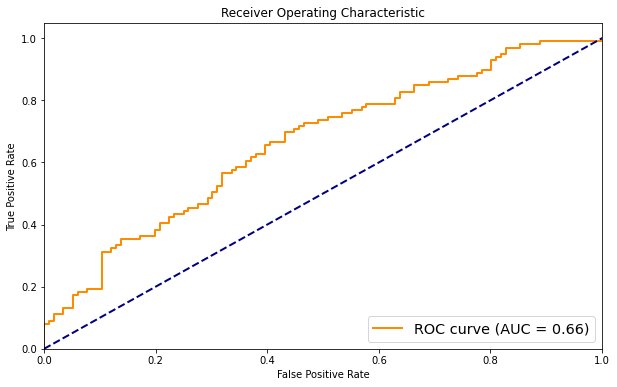

In [209]:
_ = draw_roc_curve(test_y, test_prob_EBR)

It presents worse performance than before. 

In [210]:
print("=================================================================")
print("              Resample model fairness: gender              ")
print("=================================================================")

FP = len(test_yhat_EBR[(test_X["V1_sexe_Home"]==1)&(test_y=='No')&(test_yhat_EBR=='Sí')])
TP = len(test_yhat_EBR[(test_X["V1_sexe_Home"]==1)&(test_y=='Sí')&(test_yhat_EBR=='Sí')])
FN = len(test_yhat_EBR[(test_X["V1_sexe_Home"]==1)&(test_y=='Sí')&(test_yhat_EBR=='No')])
TN = len(test_yhat_EBR[(test_X["V1_sexe_Home"]==1)&(test_y=='No')&(test_yhat_EBR=='No')])

cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)
TPR_spain = TP / (TP+FN)
FPR_spain = FP / (FP+TN)
PR_spain = (FP + TP)/(FP+TP+FN+TN)
FNR_spain = FN / (FN+TP)

FP = len(test_yhat_EBR[(test_X["V1_sexe_Dona"]==1)&(test_y=='No')&(test_yhat_EBR=='Sí')])
TP = len(test_yhat_EBR[(test_X["V1_sexe_Dona"]==1)&(test_y=='Sí')&(test_yhat_EBR=='Sí')])
FN = len(test_yhat_EBR[(test_X["V1_sexe_Dona"]==1)&(test_y=='Sí')&(test_yhat_EBR=='No')])
TN = len(test_yhat_EBR[(test_X["V1_sexe_Dona"]==1)&(test_y=='No')&(test_yhat_EBR=='No')])

cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)

TPR_foreign = TP / (TP+FN)
FPR_foreign = FP / (FP+TN)
PR_foreign = (FP + TP)/(FP+TP+FN+TN)
FNR_foreign = FN / (FN+TP)

index = ["Men", "Women", "Ratio"]
metrics = ["TPR", "FPR", 'PR', 'FNR']
data = [[TPR_spain,FPR_spain, PR_spain, FNR_spain], [TPR_foreign, FPR_foreign, PR_foreign, FNR_foreign],
       [TPR_foreign/ TPR_spain , FPR_foreign/FPR_spain, PR_foreign/ PR_spain, FNR_foreign/FNR_spain]]
display(pd.DataFrame(data, index=index, columns = metrics))

              Resample model fairness: gender              


TPR   FPR        PR       FNR
Men    0.157303  0.06  0.105820  0.842697
Women  0.100000  0.00  0.038462  0.900000
Ratio  0.635714  0.00  0.363462  1.068000

## 2.1. Is the application of this mitigation method sufficient to guarantee fair outcomes?

Observe that, in this case, by just trying to balance the proportion of input samples from each group we are actually worsening the disparity and creating highier biases. 

In order to solve this, we may need to take into account this objective on the resampling approach. 

Observe additionally, that the conditional probability of having each target value (`Sí` or `No` reividism) is strongly biased for the women population of the data set. While in the case of the men, we have more equalized distribution of the target feature. 

Thus let us consider the actual number of women we need to add to the dataset in order to get a balanced sample.

### Improving the resampling approach:

In [184]:
_women = train_X[train_X["V1_sexe_Dona"]==1]
_men = train_X[train_X["V1_sexe_Home"]==1]
print('Women prob:', len(_women))
print('Men prob:', len(_men))
additional_women = len(_men) - len(_women)
print('Women Samples to add to the data:', additional_women)

Women prob: 53
Men prob: 382
Women Samples to add to the data: 329


Additionally, following the previous comment, we may need that the additional samples are such that they balance the conditional distribution of recividism given that they come from the women population. This is, we may add the samples such that we get a nearly balanced conditional distribution. 

In [185]:
P_Y0_women = len(train_X[(train_X["V1_sexe_Dona"]==1) & (train_y == 'Sí') ])
P_Y1_women = len(train_X[(train_X["V1_sexe_Dona"]==1) & (train_y == 'No') ])
P_Y0_men = len(train_X[(train_X["V1_sexe_Home"]==1) & (train_y == 'Sí') ])
P_Y1_men = len(train_X[(train_X["V1_sexe_Home"]==1) & (train_y == 'No') ])

S_Y0 = P_women * (P_Y0_women - P_Y0_men)
S_Y1 = P_women * (P_Y1_women - P_Y1_men)
print(S_Y0, S_Y1)
print(P_Y0_women/len(train_X[train_X["V1_sexe_Dona"]==1]))
print(P_Y1_women/len(train_X[train_X["V1_sexe_Dona"]==1]))
print(P_Y0_men/len(train_X[train_X["V1_sexe_Home"]==1]))
print(P_Y1_men/len(train_X[train_X["V1_sexe_Home"]==1]))
print(P_Y0_women, P_Y1_women)

total_women = len(_women) + additional_women
women_0 = total_women/2 - P_Y0_women
women_1 = total_women/2 - P_Y1_women
print(women_0, women_1)

-19.372413793103448 -20.71264367816092
0.16981132075471697
0.8301886792452831
0.4397905759162304
0.5602094240837696
9 44
182.0 147.0


Thus we may oversample each grouping from the minority to the desired number of samples computed

In [186]:
train_Xy_3 = pd.get_dummies(train[factors+['V115_reincidencia_2015']])


In [187]:
__women = train_Xy_3[(train_Xy_3["V1_sexe_Dona"]==1) ]
__women

V8_edat_fet  V20_nombre_antecedents  V1_sexe_Dona  V1_sexe_Home  \
1093         17.0                     1.0             1             0   
1183         16.0                    10.0             1             0   
1325         17.0                     1.0             1             0   
1345         14.0                     3.0             1             0   
1254         17.0                     1.0             1             0   
999          17.0                     2.0             1             0   
1169         17.0                     1.0             1             0   
1377         15.0                     1.0             1             0   
1042         16.0                     1.0             1             0   
1365         16.0                     8.0             1             0   
1355         15.0                     1.0             1             0   
1058         16.0                     3.0             1             0   
1007         16.0                     1.0             1             0   
1279         15.0                     1.0             1             0   
1150         14.0                     1.0             1             0   
1011         17.0                     4.0             1             0   
149          14.0                     1.0             1             0   
1            14.0                     1.0             1             0   
1320         16.0                     1.0             1             0   
1256         15.0                     3.0             1             0   
151          16.0                     2.0             1             0   
210          15.0                     2.0             1             0   
1152         16.0                     1.0             1             0   
1266         14.0                     2.0             1             0   
1373         16.0                     2.0             1             0   
1223         16.0                     2.0             1             0   
1302         16.0                     2.0             1             0   
1141         15.0                     3.0             1             0   
232          15.0                     2.0             1             0   
1185         15.0                     2.0             1             0   
1370         17.0                     2.0             1             0   
1070         14.0                     3.0             1             0   
1108         16.0                     3.0             1             0   
1188         17.0                     5.0             1             0   
1381         16.0                     1.0             1             0   
1184         15.0                     2.0             1             0   
992          14.0                     3.0             1             0   
1249         16.0                     2.0             1             0   
1217         17.0                    14.0             1             0   
1319         17.0                     1.0             1             0   
201          16.0                     3.0             1             0   
1165         15.0                     1.0             1             0   
1055         14.0                     4.0             1             0   
1062         15.0                    11.0             1             0   
1029         16.0                     1.0             1             0   
29           17.0                     1.0             1             0   
985          17.0                     3.0             1             0   
1297         15.0                     1.0             1             0   
1332         16.0                     2.0             1             0   
180          17.0                    15.0             1             0   
1043         16.0                     1.0             1             0   
1161         15.0                     1.0             1             0   
1121         16.0                     3.0             1             0   

      V2_estranger_Espanyol  V2_estranger_Estranger  V15_fet_ag

In [188]:
from sklearn.utils import resample

def upsample_classes(data, target):
    
    lst = list(data[target].unique())
    
    classes = []
    for c in lst:
        classes.append(data[data[target]==c])
    
    length = 0
    class_lab = None
    for c in classes:
        if len(c)>length:
            length=len(c)
            class_lab = c
    class_lab = class_lab[target].unique()[0]
    
    regroup = pd.concat(classes)
    maj_class = regroup[regroup[target]==class_lab]

    lst.remove(class_lab)
    
    new_classes=[]
    for i in lst:
        new_classes.append(resample(data[data[target]==i],replace=True, n_samples=len(maj_class)))

    minority_classes = pd.concat(new_classes)
    upsample = pd.concat([regroup[regroup[target]==class_lab],minority_classes])

    return upsample

In [189]:
train_balanced_women = (upsample_classes(__women,'V115_reincidencia_2015_No'))
X_train_bw = train_balanced_women.drop(['V115_reincidencia_2015_No'],axis=1)
X_train_bw = X_train_bw.drop(['V115_reincidencia_2015_Sí'],axis=1)
y_train_bw = train_balanced_women.V115_reincidencia_2015_No


In [190]:
X_train_bw

V8_edat_fet  V20_nombre_antecedents  V1_sexe_Dona  V1_sexe_Home  \
1093         17.0                     1.0             1             0   
1183         16.0                    10.0             1             0   
1325         17.0                     1.0             1             0   
1345         14.0                     3.0             1             0   
1254         17.0                     1.0             1             0   
...           ...                     ...           ...           ...   
29           17.0                     1.0             1             0   
1            14.0                     1.0             1             0   
1            14.0                     1.0             1             0   
180          17.0                    15.0             1             0   
1            14.0                     1.0             1             0   

      V2_estranger_Espanyol  V2_estranger_Estranger  V15_fet_agrupat_Altres  \
1093                      1                       0                       0   
1183                      0                       1                       0   
1325                      1                       0                       0   
1345                      1                       0                       0   
1254                      1                       0                       0   
...                     ...                     ...                     ...   
29                        0                       1                       0   
1                         1                       0                       0   
1                         1                       0                       0   
180                       0                       1                       0   
1                         1                       0                       0   

      V15_fet_agrupat_Contra la propietat no violent  \
1093                                               1   
1183                                               0   
1325                                               0   
1345                                               0   
1254                                               0   
...                                              ...   
29                                                 0   
1                                                  0   
1                                                  0   
180                                                1   
1                                                  0   

      V15_fet_agrupat_Contra la propietat violent  \
1093                                            0   
1183                                            1   
1325                                            0   
1345                                            1   
1254                                            0   
...                                           ...   
29                                              0   
1                                               0   
1                                               0   
180                                             0   
1                                               0   

      V15_fet_agrupat_Contra les persones  ...  \
1093                                    0  ...   
1183                                    0  ...   
1325                                    1  ...   
1345                                    0  ...   
1254                                    1  ...   
...                                   ...  ...   
29                                      1  ...   
1                                       1  ...   
1                                       1  ...   
180                                     0  ...   
1                                       1  ...   

      V90_@P2_suport_social_fort_Absent  V90_@P2_suport_social_fort_Present  \
1093                                  1                                   0   
1183                                  1                                   0   
1325                            

In [191]:
sum(y_train_bw)

44

Now that the conditional probabilities are balanced, we can conduct the previous approach in order to oversample our dataset: 

In [192]:
train_Xy_balanced = pd.concat([train_balanced_women,train_Xy_3[(train_Xy_3["V1_sexe_Home"]==1) ] ])

cols_without_gender = train_Xy_balanced.columns.drop('V1_sexe_Home')
cols_without_gender = cols_without_gender.drop('V1_sexe_Dona')
print("Number of women before: {}".format(len(train_Xy_balanced[train_Xy_balanced['V1_sexe_Home']==0])))

P_Y0_women = len(train_Xy_balanced[(train_Xy_balanced["V1_sexe_Dona"]==1) & (train_Xy_balanced['V115_reincidencia_2015_No'] == 0) ])
P_Y1_women = len(train_Xy_balanced[(train_Xy_balanced["V1_sexe_Dona"]==1) & (train_Xy_balanced['V115_reincidencia_2015_No'] == 1) ])
P_Y0_men = len(train_Xy_balanced[(train_Xy_balanced["V1_sexe_Home"]==1) & (train_Xy_balanced['V115_reincidencia_2015_No'] == 0) ])
P_Y1_men = len(train_Xy_balanced[(train_Xy_balanced["V1_sexe_Home"]==1) & (train_Xy_balanced['V115_reincidencia_2015_No'] == 1) ])

#S_Y0 = P_women * (P_Y0_women - P_Y0_men)
#S_Y1 = P_women * (P_Y1_women - P_Y1_men)
#print(S_Y0, S_Y1)
print('Number of recivinent, given they are women:', P_Y0_women/len(train_Xy_balanced[train_Xy_balanced["V1_sexe_Dona"]==1]))
print('Number of no recivinent, given they are women:', P_Y1_women/len(train_Xy_balanced[train_Xy_balanced["V1_sexe_Dona"]==1]))
print('Number of recivinent, given they are men:', P_Y0_men/len(train_Xy_balanced[train_Xy_balanced["V1_sexe_Home"]==1]))
print('Number of no recivinent, given they are men:', P_Y1_men/len(train_Xy_balanced[train_Xy_balanced["V1_sexe_Home"]==1]))

Number of women before: 88
Number of recivinent, given they are women: 0.5
Number of no recivinent, given they are women: 0.5
Number of recivinent, given they are men: 0.4397905759162304
Number of no recivinent, given they are men: 0.5602094240837696


In [193]:
X_resampled, y_resampled = RandomOverSampler(random_state = 0).fit_resample(train_Xy_balanced[cols_without_gender], train_Xy_balanced['V1_sexe_Home'])
print(sorted(Counter(y_resampled).items()))

train_X_3 = X_resampled.copy()
a = pd.Series(y_resampled.values, index=train_X_3.index, dtype=bool)
train_X_3['V1_sexe_Home'] =a.astype(int)
train_X_3['V1_sexe_Dona'] = (~a).astype(int)
print("Number of women after: {}".format(train_X_3['V1_sexe_Home'].sum()))

train_X_4 = train_X_3.drop('V115_reincidencia_2015_Sí', axis=1)
train_X_4 = train_X_4.drop('V115_reincidencia_2015_No', axis=1)
train_y_4 = train_X_3["V115_reincidencia_2015_No"]
train_X_4 = train_X_4[test_X.columns]

P_Y0_women = len(train_X_4[(train_X_4["V1_sexe_Home"]==0) & (train_y_4 == 0) ])
P_Y1_women = len(train_X_4[(train_X_4["V1_sexe_Home"]==0) & (train_y_4 == 1) ])
P_Y0_men = len(train_X_4[(train_X_4["V1_sexe_Home"]==1) & (train_y_4 == 0) ])
P_Y1_men = len(train_X_4[(train_X_4["V1_sexe_Home"]==1) & (train_y_4 == 1) ])

#S_Y0 = P_women * (P_Y0_women - P_Y0_men)
#S_Y1 = P_women * (P_Y1_women - P_Y1_men)
#print(S_Y0, S_Y1)
print(P_Y0_women/len(train_X_4[train_X_4["V1_sexe_Dona"]==1]))
print(P_Y1_women/len(train_X_4[train_X_4["V1_sexe_Dona"]==1]))
print(P_Y0_men/len(train_X_4[train_X_4["V1_sexe_Home"]==1]))
print(P_Y1_men/len(train_X_4[train_X_4["V1_sexe_Home"]==1]))

[(0, 382), (1, 382)]
Number of women after: 382
0.4790575916230366
0.5209424083769634
0.4397905759162304
0.5602094240837696


In [198]:
train_y_4 = train_y_4.replace({0: 'Sí', 1: 'No'})
train_y_4

0      No
1      No
2      No
3      No
4      No
       ..
759    No
760    Sí
761    Sí
762    No
763    Sí
Name: V115_reincidencia_2015_No, Length: 764, dtype: object

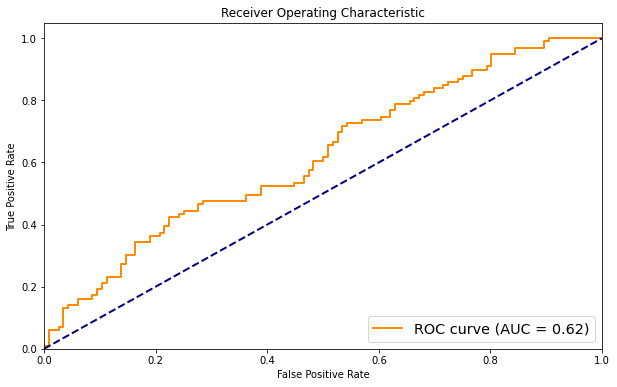

In [199]:
model_EBR = SVC(probability=True)
model_EBR.fit(train_X_4, train_y_4)
test_prob_EBR = model_EBR.predict_proba(test_X)[:,1] #probability of recividate
test_yhat_EBR = model_EBR.predict(test_X)
_ = draw_roc_curve(test_y, test_prob_EBR)

In [200]:
print("=================================================================")
print("              Resample model fairness: gender              ")
print("=================================================================")

FP = len(test_yhat_EBR[(test_X["V1_sexe_Home"]==1)&(test_y=='No')&(test_yhat_EBR=='Sí')])
TP = len(test_yhat_EBR[(test_X["V1_sexe_Home"]==1)&(test_y=='Sí')&(test_yhat_EBR=='Sí')])
FN = len(test_yhat_EBR[(test_X["V1_sexe_Home"]==1)&(test_y=='Sí')&(test_yhat_EBR=='No')])
TN = len(test_yhat_EBR[(test_X["V1_sexe_Home"]==1)&(test_y=='No')&(test_yhat_EBR=='No')])

cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)
TPR_spain = TP / (TP+FN)
FPR_spain = FP / (FP+TN)
PR_spain = (FP + TP)/(FP+TP+FN+TN)
FNR_spain = FN / (FN+TP)

FP = len(test_yhat_EBR[(test_X["V1_sexe_Dona"]==1)&(test_y=='No')&(test_yhat_EBR=='Sí')])
TP = len(test_yhat_EBR[(test_X["V1_sexe_Dona"]==1)&(test_y=='Sí')&(test_yhat_EBR=='Sí')])
FN = len(test_yhat_EBR[(test_X["V1_sexe_Dona"]==1)&(test_y=='Sí')&(test_yhat_EBR=='No')])
TN = len(test_yhat_EBR[(test_X["V1_sexe_Dona"]==1)&(test_y=='No')&(test_yhat_EBR=='No')])

cf_matrix_1 = np.array([[TN, FP], [FN, TP]]).reshape(2,2)

TPR_foreign = TP / (TP+FN)
FPR_foreign = FP / (FP+TN)
PR_foreign = (FP + TP)/(FP+TP+FN+TN)
FNR_foreign = FN / (FN+TP)

index = ["Men", "Women", "Ratio"]
metrics = ["TPR", "FPR", 'PR', 'FNR']
data = [[TPR_spain,FPR_spain, PR_spain, FNR_spain], [TPR_foreign, FPR_foreign, PR_foreign, FNR_foreign],
       [TPR_foreign/ TPR_spain , FPR_foreign/FPR_spain, PR_foreign/ PR_spain, FNR_foreign/FNR_spain]]
display(pd.DataFrame(data, index=index, columns = metrics))

              Resample model fairness: gender              


TPR       FPR        PR       FNR
Men    0.348315  0.180000  0.259259  0.651685
Women  0.500000  0.250000  0.346154  0.500000
Ratio  1.435484  1.388889  1.335165  0.767241

Observe that eventhough the predictions may be worse (which could have been expected since the oversampling actually tries to generate random new samples taking into account the possile input distribution, which for the women group which have taget value `Sí` has to be determined from 9 samples). However, note that the obtained fairness metrics are somehow more biased towards benefitting the women group in most of the cirterium.  

Therefore, on both approaches, performing just EBR and trying an alternative EBR starting from a more balanced dataset taking into account the conditional probabilities, we end up with a shift disparity between men and women. On the first approach we got a discrimination against men, and on this approach we ended upwith a discrimination on the opposite direction, discriminating against women (we got ratios of the fairness criterion above 1). A possible cause is the fact that there are considerably less women in the training data set. Thus, over-sampling data or encoding data transforms the training data in unexpected ways.

# Exercise 3

In order to see which fearures are important for different predictive models we can use ML explainability models. 

Apply ML explainability models to the (i) human risk assessment score, (ii) to the SAVRY baseline model, and (iii) to the best ML model (in terms of performance). 

### Questions

1. Which are the top ten most important features of each model?

2. Look at the features thar are important for the best ML model after the application of the equalized base rates (EBR) mitigation stratgey. Is there any difference?

## Solution Exercise 3

Over the last few years, there has been significant progress on Explainable AI. The pursuit of converting these black box models into transparent and interpretable algorithms has gained traction in both the academic and business world.


### 1. Human risk assessment score

Recall that this score was given by the corresponding feature from the initial dataset `V56_@R1_resum_risc_global_reverse` which was provided by human experts. Recall that this score was initially classified into 3 cathegories, but we decided to convert it into a binary target feature so we could compare its accuracy with other models trained on the previous sections. 

In [211]:
test_y_human = test['V56_@R1_resum_risc_global_reverse'].map(human_to_risk)
accuracy_score(test_y, test_y_human)

0.5906976744186047

Note however that this variable was determined by human professional so maybe the best ways to find a possible explanation is to consider the possible correlation with other variables on the original dataset. In order to do so, consider the correlation matrix on the initial dataset, when converted to a dummies dataset.

In [219]:
train_Xy_3_1 = pd.get_dummies(train[factors+['V56_@R1_resum_risc_global_reverse']])


In [222]:
corr_matrix = train_Xy_3_1.corr()
corr_matrix[-3:]

V8_edat_fet  \
V56_@R1_resum_risc_global_reverse_Alta        -0.108354   
V56_@R1_resum_risc_global_reverse_Baixa        0.051951   
V56_@R1_resum_risc_global_reverse_Moderada     0.038794   

                                            V20_nombre_antecedents  \
V56_@R1_resum_risc_global_reverse_Alta                    0.190446   
V56_@R1_resum_risc_global_reverse_Baixa                  -0.225219   
V56_@R1_resum_risc_global_reverse_Moderada                0.059004   

                                            V1_sexe_Dona  V1_sexe_Home  \
V56_@R1_resum_risc_global_reverse_Alta         -0.086150      0.086150   
V56_@R1_resum_risc_global_reverse_Baixa         0.075623     -0.075623   
V56_@R1_resum_risc_global_reverse_Moderada     -0.001752      0.001752   

                                            V2_estranger_Espanyol  \
V56_@R1_resum_risc_global_reverse_Alta                  -0.136484   
V56_@R1_resum_risc_global_reverse_Baixa                  0.100480   
V56_@R1_resum_risc_global_reverse_Moderada               0.015582   

                                            V2_estranger_Estranger  \
V56_@R1_resum_risc_global_reverse_Alta                    0.136484   
V56_@R1_resum_risc_global_reverse_Baixa                  -0.100480   
V56_@R1_resum_risc_global_reverse_Moderada               -0.015582   

                                            V15_fet_agrupat_Altres  \
V56_@R1_resum_risc_global_reverse_Alta                   -0.007136   
V56_@R1_resum_risc_global_reverse_Baixa                  -0.026795   
V56_@R1_resum_risc_global_reverse_Moderada                0.031255   

                                            V15_fet_agrupat_Contra la propietat no violent  \
V56_@R1_resum_risc_global_reverse_Alta                                           -0.082743   
V56_@R1_resum_risc_global_reverse_Baixa                                           0.072632   
V56_@R1_resum_risc_global_reverse_Moderada                                       -0.001683   

                                            V15_fet_agrupat_Contra la propietat violent  \
V56_@R1_resum_risc_global_reverse_Alta                                         0.039352   
V56_@R1_resum_risc_global_reverse_Baixa                                       -0.045552   
V56_@R1_resum_risc_global_reverse_Moderada                                     0.011256   

                                            V15_fet_agrupat_Contra les persones  \
V56_@R1_resum_risc_global_reverse_Alta                                 0.040478   
V56_@R1_resum_risc_global_reverse_Baixa                               -0.000141   
V56_@R1_resum_risc_global_reverse_Moderada                            -0.032792   

                                            ...  \
V56_@R1_resum_risc_global_reverse_Alta      ...   
V56_@R1_resum_risc_global_reverse_Baixa     ...   
V56_@R1_resum_risc_global_reverse_Moderada  ...   

                                            V91_@P3_forta_vinculacio_adult_prosocial_Present  \
V56_@R1_resum_risc_global_reverse_Alta                                             -0.216963   
V56_@R1_resum_risc_global_reverse_Baixa                                             0.258813   
V56_@R1_resum_risc_global_reverse_Moderada                                         -0.069343   

                                            V92_@P4_actitud_positiva_intervencions_autoritat_Absent  \
V56_@R1_resum_risc_global_reverse_Alta                                               0.408815         
V56_@R1_resum_risc_global_reverse_Baixa                                             -0.309482         
V56_@R1_resum_risc_global_reverse_Moderada                                          -0.038589         

                                            V92_@P4_actitud_positiva_intervencions_autoritat_Present  \
V56_@R1_resum_risc_global_reverse_Alta                                              -0.408815          
V56_@R1_resum_risc_global_reverse_Baixa                                              0.309482          


In [224]:
thres = 0.5

for row in range(0, 3):
    print(corr_matrix.index[-row-1])
    for col in corr_matrix.columns:
        if abs(corr_matrix.iloc[-row-1][col]) > thres: 
            print(col)

V56_@R1_resum_risc_global_reverse_Moderada
V56_@R1_resum_risc_global_reverse_Baixa
V56_@R1_resum_risc_global_reverse_Moderada
V56_@R1_resum_risc_global_reverse_Baixa
V56_@R1_resum_risc_global_reverse_Baixa
V56_@R1_resum_risc_global_reverse_Moderada
V56_@R1_resum_risc_global_reverse_Alta
V56_@R1_resum_risc_global_reverse_Alta


In [225]:
thres = 0.4

for row in range(0, 3):
    print(corr_matrix.index[-row-1])
    for col in corr_matrix.columns:
        if abs(corr_matrix.iloc[-row-1][col]) > thres: 
            print(col)

V56_@R1_resum_risc_global_reverse_Moderada
V56_@R1_resum_risc_global_reverse_Alta
V56_@R1_resum_risc_global_reverse_Baixa
V56_@R1_resum_risc_global_reverse_Moderada
V56_@R1_resum_risc_global_reverse_Baixa
V75_@11_delinquencia_grup_iguals_Baix
V81_@17_actitud_negatives_Baix
V85_@21_baix_nivell_empatia_remordiment_Baix
V87_@23_baixa_colaboracio_intervencions_Baix
V56_@R1_resum_risc_global_reverse_Baixa
V56_@R1_resum_risc_global_reverse_Moderada
V56_@R1_resum_risc_global_reverse_Alta
V75_@11_delinquencia_grup_iguals_Alt
V81_@17_actitud_negatives_Alt
V82_@18_assumpcio_riscos_impulsivitat_Alt
V84_@20_problemes_maneig_enuig_Alt
V92_@P4_actitud_positiva_intervencions_autoritat_Absent
V92_@P4_actitud_positiva_intervencions_autoritat_Present
V56_@R1_resum_risc_global_reverse_Alta
V56_@R1_resum_risc_global_reverse_Moderada


#### Top 10 features for this model:

The top ten features for this model are the ones given by the correlation study, since we do not have more information on the model or approach used by the human experts. Therefore, regarding that the 3 dummy variables of the risk correspond to the target value, we have the following ten most important features:

In [230]:
corr_matrix['V56_@R1_resum_risc_global_reverse_Baixa'].sort_values()[:13]

V56_@R1_resum_risc_global_reverse_Moderada                -0.653012
V94_@P6_perseverança_tret_personalitat_Absent             -0.373024
V56_@R1_resum_risc_global_reverse_Alta                    -0.364900
V93_@P5_fort_compromis_escola_treball_Absent              -0.353940
V90_@P2_suport_social_fort_Absent                         -0.348155
V81_@17_actitud_negatives_Moderat                         -0.340148
V89_@P1_impicacio_prosocial_Absent                        -0.337923
V75_@11_delinquencia_grup_iguals_Alt                      -0.326278
V82_@18_assumpcio_riscos_impulsivitat_Alt                 -0.318040
V92_@P4_actitud_positiva_intervencions_autoritat_Absent   -0.309482
Name: V56_@R1_resum_risc_global_reverse_Baixa, dtype: float64

In [231]:
corr_matrix['V56_@R1_resum_risc_global_reverse_Moderada'].sort_values()[:13]

V56_@R1_resum_risc_global_reverse_Baixa                 -0.653012
V56_@R1_resum_risc_global_reverse_Alta                  -0.466842
V78_@14_escassa_habilitat_pares_educar_Baix             -0.219249
V75_@11_delinquencia_grup_iguals_Baix                   -0.187442
V77_@13_estrés_incapacitat_enfrontar_dificultats_Baix   -0.169199
V79_@15_manca_suport_personal_social_Baix               -0.168988
V84_@20_problemes_maneig_enuig_Baix                     -0.166529
V81_@17_actitud_negatives_Baix                          -0.160929
V82_@18_assumpcio_riscos_impulsivitat_Baix              -0.145665
V81_@17_actitud_negatives_Alt                           -0.132589
Name: V56_@R1_resum_risc_global_reverse_Moderada, dtype: float64

In [232]:
corr_matrix['V56_@R1_resum_risc_global_reverse_Alta'].sort_values()[:13]

V56_@R1_resum_risc_global_reverse_Moderada                 -0.466842
V92_@P4_actitud_positiva_intervencions_autoritat_Present   -0.408815
V81_@17_actitud_negatives_Baix                             -0.374785
V56_@R1_resum_risc_global_reverse_Baixa                    -0.364900
V87_@23_baixa_colaboracio_intervencions_Baix               -0.357580
V85_@21_baix_nivell_empatia_remordiment_Baix               -0.338198
V90_@P2_suport_social_fort_Present                         -0.314177
V93_@P5_fort_compromis_escola_treball_Present              -0.313074
V94_@P6_perseverança_tret_personalitat_Present             -0.294011
V89_@P1_impicacio_prosocial_Present                        -0.290680
Name: V56_@R1_resum_risc_global_reverse_Alta, dtype: float64

We get some information on some features that may be correlated with the human risk index. However, note that on the one hand this is lacks of information, since the correlation matrix can only detect relations among features that may be linear, which misses a high amount of information we could actually get from the patterns or relations between the features. On the other hand, since it has not been defined an actual model in order to predict this target value it is difficult to determine an approach of ML explainability on this feature, since we are not actually applying ML to get predictions.  

### 2. SAVRY baseline model

On the frist hand, consider we are refering to the `V60_SAVRY_total_score`, in which case we may need to compute again the correlation matrix, restricted to the limitations it presents as aforementioned. 

In [229]:
train_Xy_3_2 = pd.get_dummies(train[factors+['V60_SAVRY_total_score']])

train_Xy_3_2.corr()['V60_SAVRY_total_score'].sort_values()[:10]

V81_@17_actitud_negatives_Baix                 -0.630570
V85_@21_baix_nivell_empatia_remordiment_Baix   -0.586559
V87_@23_baixa_colaboracio_intervencions_Baix   -0.568363
V68_@4_fracas_intervencions_anteriors_Baix     -0.557755
V79_@15_manca_suport_personal_social_Baix      -0.522591
V90_@P2_suport_social_fort_Present             -0.497065
V67_@3_inici_precoç_violencia_Baix             -0.496301
V75_@11_delinquencia_grup_iguals_Baix          -0.492362
V71_@7_historia_maltracte_infantil_Baix        -0.489347
V84_@20_problemes_maneig_enuig_Baix            -0.486688
Name: V60_SAVRY_total_score, dtype: float64

Consider now the case we are refering to the initial proposed model, for the recividism using the initial features, taking intoa ccount all of them. Recall the SAVRY baseline model proposed at the beginning of this notebook:

In [233]:
train, test = train_test_split(df, test_size=0.33)

factors = demographic_columns + risk_factor_columns + protective_factor_columns

train_X = pd.get_dummies(train[factors])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[factors])
test_y = test["V115_reincidencia_2015"]

In [234]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [235]:
predALL_y = model.predict_proba(test_X)[:,1]
predALL_recidivists = predALL_y[test_y == 'Sí']
predALL_non_recidivists = predALL_y[test_y == 'No']

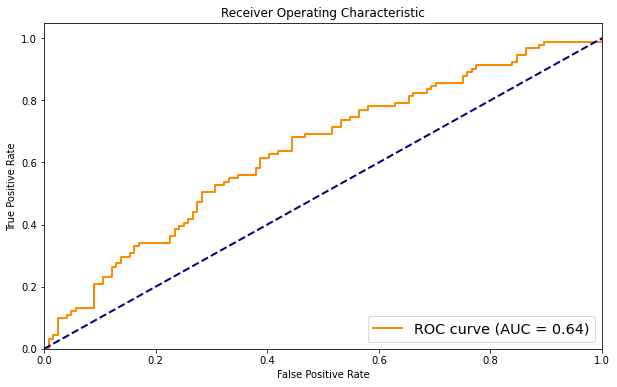

In [236]:
_ = draw_roc_curve(test_y, predALL_y)

In [237]:
predALL_yhat = model.predict(test_X)
accuracy = accuracy_score(test_y, predALL_yhat)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 60.00%


There are multiple ways to measure feature importance. *Mean decrease importance* is one of the simplest and, in spite of the fact of its limitations, it can be used in a very fast way.

Let us, first of all use the package `eli5` to study the explainability from the point of view of the relevance on the feature. We have already seen some insight on the correlations, and now we may analyse how the model changes when some deviations or perturbations are conducted over certain features. 


In [238]:
#pip install shap

     |████████████████████████████████| 436 kB 4.0 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [242]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(model, random_state=1).fit(test_X, test_y)
eli5.show_weights(perm, feature_names = test_X.columns.tolist())


2023-05-01 18:47:16.070805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The values towards the top are the most important features, and those towards the bottom matter least. Since we have a wide range of features, the less important features are not even shown on the table. 

The first number in each row shows how much model performance decreased with a random shuffling (in this case, using "accuracy" as the performance metric).

Like most things in data science, there is some randomness to the exact performance change from a shuffling a column. We measure the amount of randomness in our permutation importance calculation by repeating the process with multiple shuffles. The number after the ± measures how performance varied from one-reshuffling to the next.

In cases we find negative values for permutation importances, the predictions on the shuffled (or noisy) data happened to be more accurate than the real data. This happens when the feature didn't matter (should have had an importance close to 0), but random chance caused the predictions on shuffled data to be more accurate. Note that among the shown features, there is no feature with negative value. 

We see that an important feature on the model is `nombre_antecedents` which actually could make sense, since we are predicting the probability of commiting again a crime, it could be of important relevance whether the individual ahs commited several times before a crime.  

While feature importance shows **what** variables most affect predictions, partial dependence plots show **how** a feature affects predictions. We may therefore study this aspect by using the `pdpbox` package. 

In [243]:
#!pip install pdpbox

In [244]:
from matplotlib import pyplot as plt
from pdpbox import pdp, get_dataset, info_plots

# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=model, 
                            dataset=test_X, 
                            model_features=test_X.columns.tolist(), 
                            feature='V20_nombre_antecedents')


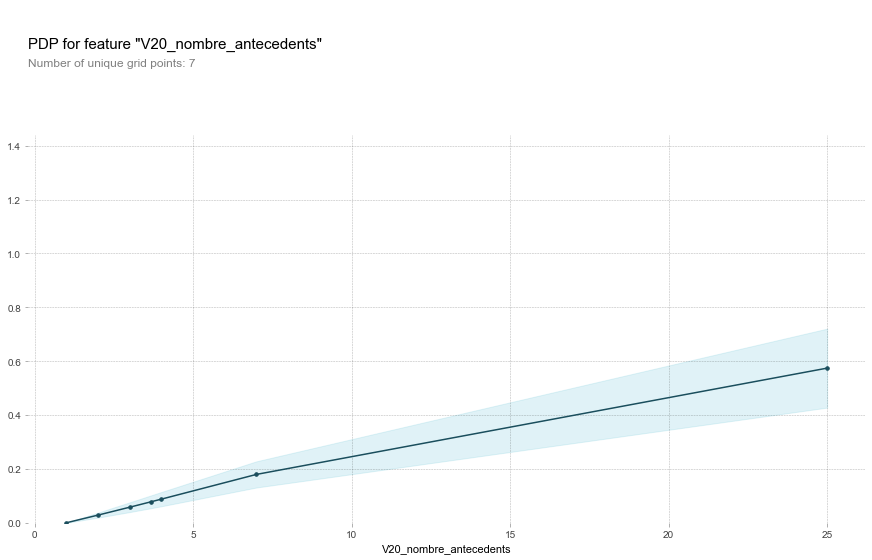

In [245]:
# plot it
pdp.pdp_plot(pdp_goals, 'V20_nombre_antecedents')
plt.show()

The `y` axis is interpreted as change in the prediction from what it would be predicted at the baseline or leftmost value.

A blue shaded area indicates level of confidence.

From this particular graph, the explanation we can produce is: **Having more than 5 antecedents increases the chances of commiting recividism. In fact, the slope of increase changes when we reach 7 antecedents, and then the relationship increases slightly slowly. Then we can think that once you have commited more than 7 crimes, there is less impact on the predictions.**


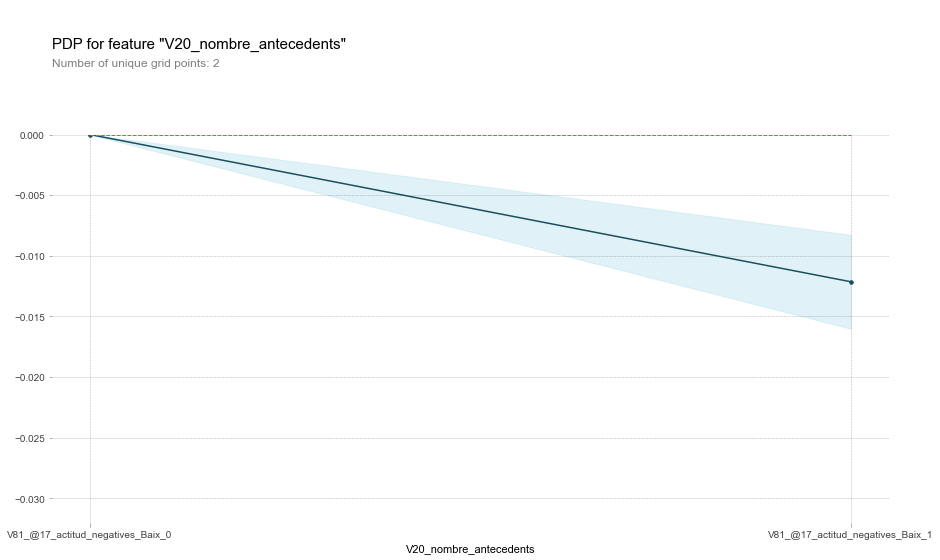

In [247]:
col_to_study = 'V81_@17_actitud_negatives_Baix'
pdp_goals = pdp.pdp_isolate(model=model, 
                            dataset=test_X, 
                            model_features=test_X.columns.tolist(), 
                            feature=col_to_study)
# plot it
pdp.pdp_plot(pdp_goals, 'V20_nombre_antecedents')
plt.show()

Using this approach it is difficult to study with more detail the boolean features or the dummies obtained from the cathegorical features. 

Let's consider now the package `shap`:

SHAP, which stands for SHapley Additive exPlanations, is a state-of-the-art Machine Learning explainability. This algorithm was first published in 2017 by Lundberg and Lee and is a way to reverse-engineer the output of any predictive algorithm.

SHAP is based on a concept from game theory where we have the game of reproducing the model's outcome, and players are the features included in the model. SHAP quantifies the contribution that each player brings to the game.

In [248]:
explainer = shap.Explainer(model, train_X, feature_names=train_X.columns.tolist())
shap_values = explainer(test_X)

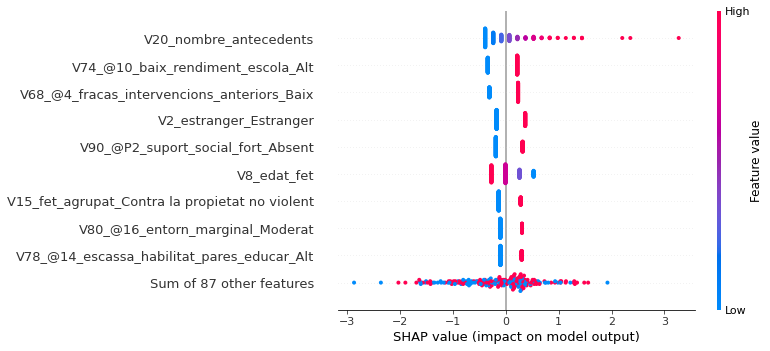

In [249]:
shap.plots.beeswarm(shap_values)

In [254]:
shap.initjs()
ind = 0
shap.plots.force(shap_values[ind])

If we take many force plot explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [257]:
# visualize all the training set predictions
shap.plots.force(shap_values)

If we filter by `nombre antecedents` on this plot we can clearly see its effect on the predictions. There are multiple other options of interaction with this plot in order to get a more complete sense of the features' interactions over the model.

Consider now the `waterfall` plot. 

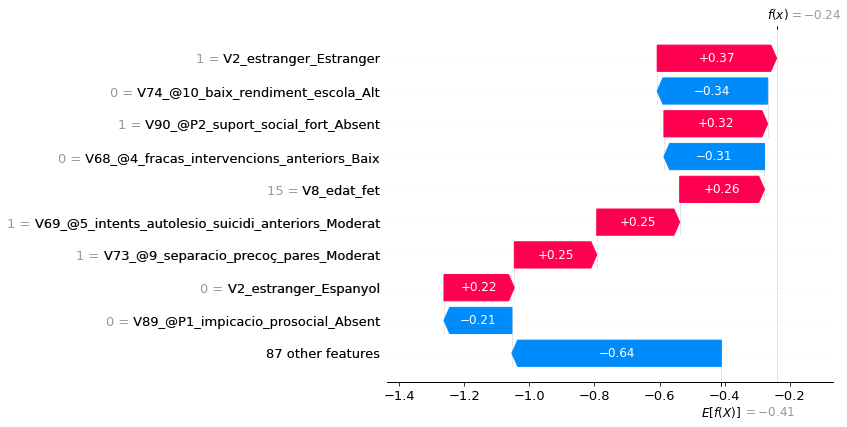

<Figure size 432x288 with 0 Axes>

In [255]:
fig = shap.plots.waterfall(shap_values[ind])
plt.tight_layout()

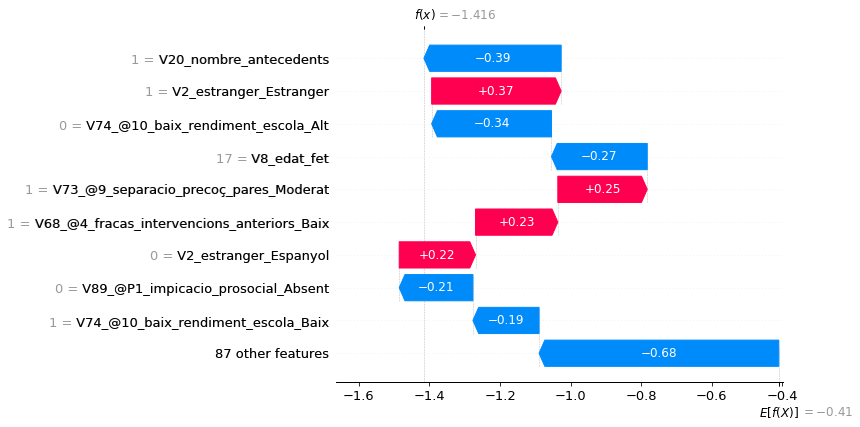

<Figure size 432x288 with 0 Axes>

In [256]:
fig = shap.plots.waterfall(shap_values[1])
plt.tight_layout()

Waterfall plots display explanations for an individual prediction. Each row shows how each feature's positive (red) or negative (blue) contribution moves the value from the expected model output for this prediction.

Looking at the x-axis, we can see the expected value is E[f(x)] = -0.41. This value is the average predicted number across all observations. The ending value is f(x) = -1.416 is the predicted number for this observation. Since we have a binary target value, this prediction for being negative may end up predicting one of the two target classes. 


#### Top ten most important features:

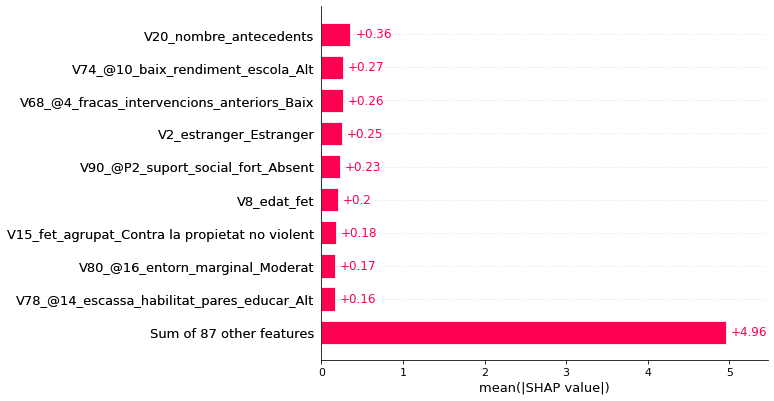

In [258]:
shap.plots.bar(shap_values)

#### Some mathematics on the explainability

Recall that actually the logistic regression is given by the expression 
$$
p(y_i = 1) = \frac{1}{1 + exp(-(\hat{\beta}_0 + \hat{\beta}_1 x_1^i+ \dots \hat{\beta}_p x_p^i))}
$$
which can actually be interpreted as that fro any change in one feature by 1 unit, the prediction value changes the *odds* ratio by a factor of exp$(\hat{\beta}_j)$. Thus, the SHAP values computed above can be thought as an approximation of those coefficients which determine the actual impact that the feature has over the prediction. We have seen therefore, that the feature that has highier coefficient is the `nombre_ascendents` variable, this means that the $\hat{\beta}_{nombreAscendents}$ is the greater coefficient of all, generating the highier impact on the prediction. 

### 3. best ML model (in terms of performance). 

Generally the best performance is obtained by either the SVM or the Gaussian process model. Therefore let's consider both of them and retrain them, and we may choose the one that provides the best performance in this particular case:

#### Define the ML models:

In [280]:
random_seed = 1
train, test = train_test_split(df, test_size=0.33, random_state = random_seed )

train_X = pd.get_dummies(train[factors])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[factors])
test_y = test["V115_reincidencia_2015"]

In [281]:
model1 = GaussianProcessClassifier(kernel=Matern(), random_state = random_seed)
model1.fit(train_X, train_y)
test_prob1 = model1.predict_proba(test_X)[:,1] #probability of recividate
test_yhat1 = model1.predict(test_X)

In [282]:
model2 = SVC(probability=True, random_state = random_seed)
model2.fit(train_X, train_y)
test_prob2 = model2.predict_proba(test_X)[:,1] #probability of recividate
test_yhat2 = model2.predict(test_X)

In [283]:
print(accuracy_score(test_y, test_yhat1))
print(accuracy_score(test_y, test_yhat2))

0.6325581395348837
0.6604651162790698


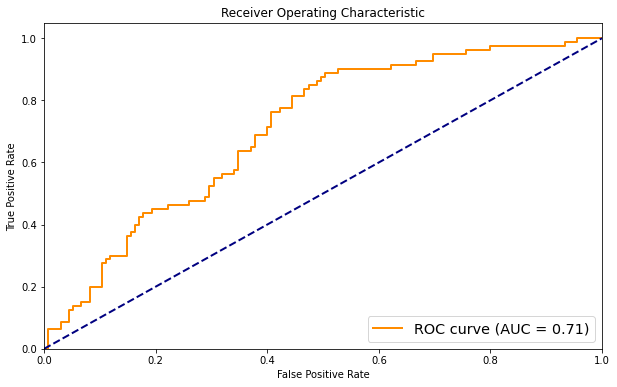

In [284]:
_ = draw_roc_curve(test_y, test_prob1)

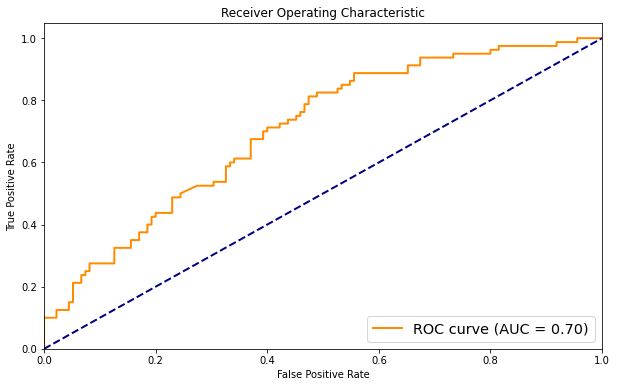

In [285]:
_ = draw_roc_curve(test_y, test_prob2)

As expected both have similar AUC metrics, although the SVM has slightly highier accuracy rate. Let us consider for example the SVM model for the subsequent study, eventhough bth of them show similar performance over the problem. 

#### Feature impact with `eli5`

The importance of a feature is the increase in the prediction
error of the model after we permuted the feature’s values,
which breaks the relationship between the feature and the
true outcome. This is, A feature is “important” if shuffling its values increases the model error, because in this case the model relied on the
feature for the prediction.
Similarly, a feature is “unimportant” if shuffling its values leaves the
model error unchanged, because in this case the model ignored
the feature for the prediction.

In [286]:
perm = PermutationImportance(model2, random_state=1).fit(test_X, test_y)
eli5.show_weights(perm, feature_names = test_X.columns.tolist())


Notice that again, the feature with highier impact on the prediction is the `nombre_antecedents`, being a clear indicator of whether an individual which already has committed several crimes will commit recividism. 

#### Partial Dependence plots with `pdpbox` 

The partial dependence plot (PDP) method shows the
marginal effect one (or two features) have on the predicted
outcome of a machine learning model.

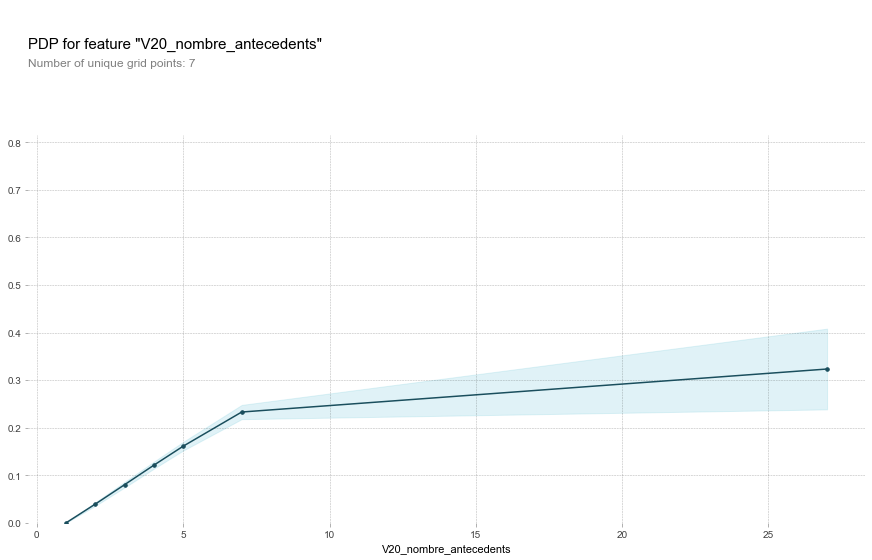

In [289]:
# Create the data that we will plot
pdp_goals = pdp.pdp_isolate(model=model2, 
                            dataset=test_X, 
                            model_features=test_X.columns.tolist(), 
                            feature='V20_nombre_antecedents')
# plot it
pdp.pdp_plot(pdp_goals, 'V20_nombre_antecedents')
plt.show()

Observe that here the impact is more significant than in the baseline model, this is, the change on slope seem more contrasted once we reach 7 actecedents crime commited before. Once this number is reached, it is less significant and has minor impact on the prediction the additional times the crime has been committed before the current moment.

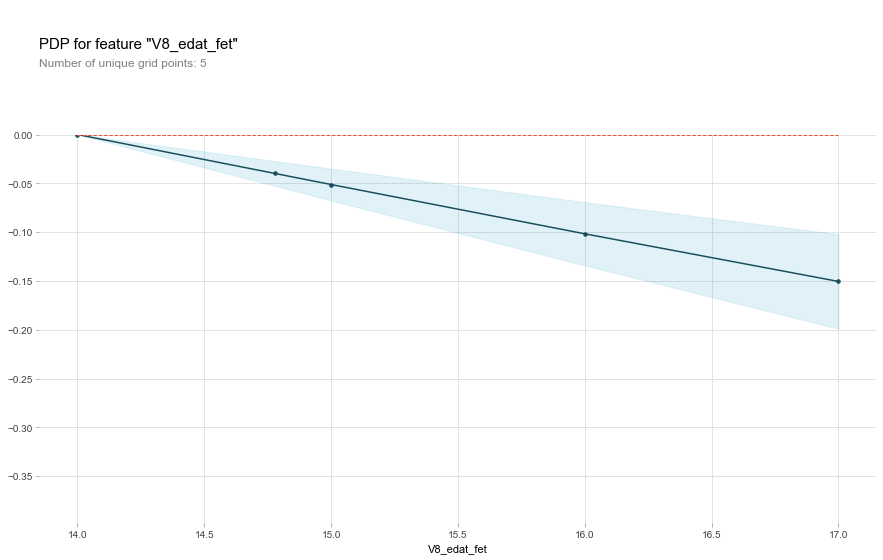

In [290]:
col_to_study = 'V8_edat_fet'
pdp_goals = pdp.pdp_isolate(model=model, 
                            dataset=test_X, 
                            model_features=test_X.columns.tolist(), 
                            feature=col_to_study)
# plot it
pdp.pdp_plot(pdp_goals, col_to_study)
plt.show()

Regarding the age at which the crime occured, notice that the dependency is linear and it does no have a clear change on slope. 

#### Explainer with `shap` 

In [297]:
explainer = shap.Explainer(model2.predict_proba, train_X, feature_names=train_X.columns.tolist())
shap_values = explainer(test_X)



Permutation explainer: 216it [07:59,  2.26s/it]                         


'\nTypeError: The passed model is not callable and cannot be analyzed directly \nwith the given masker! Model: SVC(probability=True, random_state=1)\n'

In [301]:
explainer = shap.KernelExplainer(model2.predict_proba, train_X, feature_names=train_X.columns.tolist())
shap_values = explainer.shap_values(test_X)


Using 435 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/215 [00:00<?, ?it/s]

NameError: name 'X_test' is not defined

In [302]:

shap.force_plot(explainer.expected_value[0], shap_values[0], test_X)


#### Alternative comparison from `sklearn`

Let's conduct a similar study over the features that have greater impact to the one obtained using the `shap` package but using an alternative approach. 

In [295]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model2, test_X, test_y, n_repeats=10, random_state=random_seed, n_jobs=2)


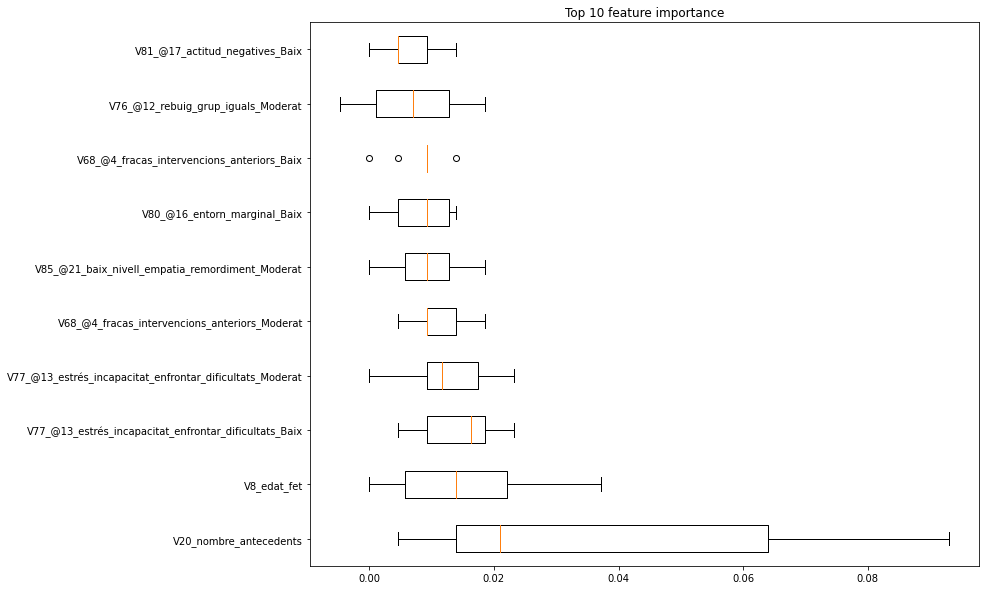

In [296]:
importances = result.importances_mean
order = np.argsort(importances)[::-1]
sorted_importances = result.importances[order]
sorted_features = test_X.columns[order]

top_10, top_10_order, top_10_names = sorted_importances[:10], order[:10], sorted_features[:10]
plt.figure(figsize=(12,10))
plt.subplot()
plt.title("Top 10 feature importance")
plt.boxplot(top_10.T, vert=False, labels = top_10_names)#, labels=factors[sorted_idx]);
plt.show()

## Questions 

### 1. Which are the top ten most important features of each model?

For each model, the top ten most important features have been listed on the last section of the corresponding sub-exercise of that specific model. Notice that when studying the actual ML explainability, the top most important feature for the different models is the `nombre_antecedents`, which as aforementioned is quite coherent when taking into account the problem considered. 

### 2. Look at the features that are important for the best ML model after the application of the equalized base rates (EBR) mitigation strategy. Is there any difference?

In [306]:
#result = permutation_importance(model_EBR, test_X, test_y.map(lambda x: 1 if x=='Sí' else 0), n_repeats=10, random_state=42, n_jobs=2)
result = permutation_importance(model_EBR, test_X, test_y, n_repeats=10, random_state=42, n_jobs=2)



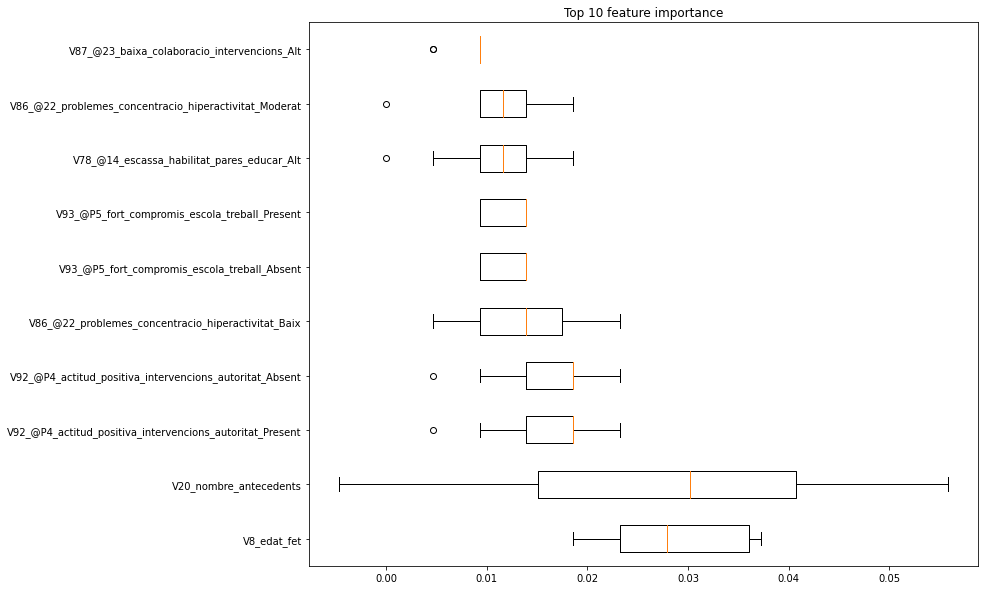

In [307]:
importances = result.importances_mean
order = np.argsort(importances)[::-1]
sorted_importances = result.importances[order]
sorted_features = test_X.columns[order]

top_10, top_10_order, top_10_names = sorted_importances[:10], order[:10], sorted_features[:10]
plt.figure(figsize=(12,10))
plt.subplot()
plt.title("Top 10 feature importance")
plt.boxplot(top_10.T, vert=False, labels = top_10_names)#, labels=factors[sorted_idx]);
plt.show()

Notice that when considering the EBR approach of mitigation, we get different importance on the features over the preditions, which is generated by the patterns that the model has learnt before the training in order to generate random extra samples. 

For example the `edat_fet` seems to be more important and the `nombre_antecedents` feature has incrementet significantly its standard deviation. This could be drawn from the random generation of new samples again. 

### Bibliography for this Exercise:

- https://shap.readthedocs.io/en/latest/index.html
- https://towardsdatascience.com/explainable-ai-xai-a-guide-to-7-packages-in-python-to-explain-your-models-932967f0634b
- https://www.dataknowsall.com/explainability.html
- https://github.com/slundberg/shap
- Notebooks and note course of the Ethical Data Science course (MsC on Fundamental Principles of Data Science, UB)